In [1]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pandas as pd
def correlation_center_finder(grid1, grid2):
    def cycle_matrix(matrix, row_shift, col_shift):
        row_shift %= matrix.shape[0]
        col_shift %= matrix.shape[1]
        return np.roll(np.roll(matrix, row_shift, axis=0), col_shift, axis=1)
    def compare_matrices_ssim(matrix1, matrix2):
        data_range = max(Data_abv.max(), Data_blw.max()) - min(Data_abv.min(), Data_blw.min())
        return np.abs(ssim(matrix1, matrix2, data_range=data_range)) # Have |SSIM| it 
    def center_list(n):
        midpoint = n // 2
        return np.arange(-midpoint, n - midpoint)
    xs = center_list(grid1.shape[1])
    ys = center_list(grid1.shape[0])
    correlations = [
        (x, y, compare_matrices_ssim(grid1, cycle_matrix(grid2, y, x)))
        for x in xs for y in ys
    ]
    df = pd.DataFrame(correlations, columns=['Right', 'Up', 'Correlation'])
    best_shift = df.loc[df['Correlation'].idxmax()]
    return df, best_shift['Up'], best_shift['Right']
    
from shapely.geometry import Polygon
def calculate_centroid(xt, yt):
    if len(xt) == 0:
        return np.nan, np.nan
    polygon = Polygon(zip(xt, yt))
    centroid = polygon.centroid
    return centroid.x, centroid.y
    
def calculate_okubo_weis(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(LOW):
    ocean_mask = np.where(np.isnan(LOW), np.zeros_like(LOW), 1)
    OW_mean = np.nansum(LOW) / np.sum(ocean_mask)
    OW_std = np.sqrt(np.nansum(ocean_mask * (LOW - OW_mean) ** 2) / np.sum(ocean_mask))
    return LOW / OW_std

def make_cartesian(lon, lat, theta0, phi0):
    lonr, latr = np.deg2rad(lon), np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(np.deg2rad(phi0)) * (lonr - np.deg2rad(theta0))
    y = r_earth * (latr - np.deg2rad(phi0))
    return x, y



In [2]:
def calculate_eddy(width=500000, num_depth_layers=10, eta0=1, L=1e5, H=1200, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0.01, alpha_2=0.01, T0=20, dTdz=.005, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, and temperature field for an ocean eddy.
    
    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a: Linear coefficient for stratification.
    - b: Exponential coefficient for density anomaly.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1: Coefficient for x_c(z), affects the horizontal shift of the eddy center with depth in the x direction.
    - alpha_2: Coefficient for y_c(z), affects the horizontal shift of the eddy center with depth in the y direction.
    - T0: Surface temperature at z = 0 (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    
    Returns:
    - U: 3D matrix for the U (x-component) velocity field.
    - V: 3D matrix for the V (y-component) velocity field.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - CS: Speed magnitude.
    """

    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -40 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width//2, width//2, 100)  # x-coordinates
    y = np.linspace(-width//2, width//2, 100)  # y-coordinates
    # z = np.linspace(-H*1.3, 0, num_depth_layers)  # Depth levels from surface (0) to -H
    z = np.linspace(-400*1.3, 0, num_depth_layers)

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = 1
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    def g_z(z, H, taper_factor):

        if taper_depth is None:
            return 1
        else:
            return np.exp(z / H) * taper_factor

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.sqrt((x_3d - x_c)**2 + (y_3d - y_c)**2)

    # Calculate density anomaly sigma with the modified equation
    sigma = rho0 - a * z_3d + b * f_r_rc(r_c, L) * g_z(z_3d, H, taper_factor)

    ########## Calculate 3D geostrophic velocity components for the eddy from the density field ####################

    # Compute partial derivatives of sigma with respect to x and y
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    
    d_sigma_dx = np.gradient(sigma, axis=0) / dx  # Partial derivative wrt x
    d_sigma_dy = np.gradient(sigma, axis=1) / dy  # Partial derivative wrt y

    U = g / f0 * d_sigma_dy  # Directly use the gradients - produces realsitic current speeds
    V = - g / f0 * d_sigma_dx

    U *= taper_factor
    V *= taper_factor

    #########################################################################################################

    # Calculate speed magnitude
    CS = np.sqrt(U**2 + V**2)
    
    # Calculate temperature as a linear function of depth with horizontal variation
    # T0 is the surface temperature, dTdz is the rate of temperature decrease with depth
    # T = T0 + dTdz * z_3d - 0.5 * f_r_rc(r_c, L)  # Horizontal variation based on distance from the eddy center
    T = - 0.5 * f_r_rc(r_c, L)

    T *= taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    CS  = np.flip(CS, axis=2)
    z = np.flip(z)
    
    return U, V, sigma, T, CS, x/1000, y/1000, z


## No-Tilt

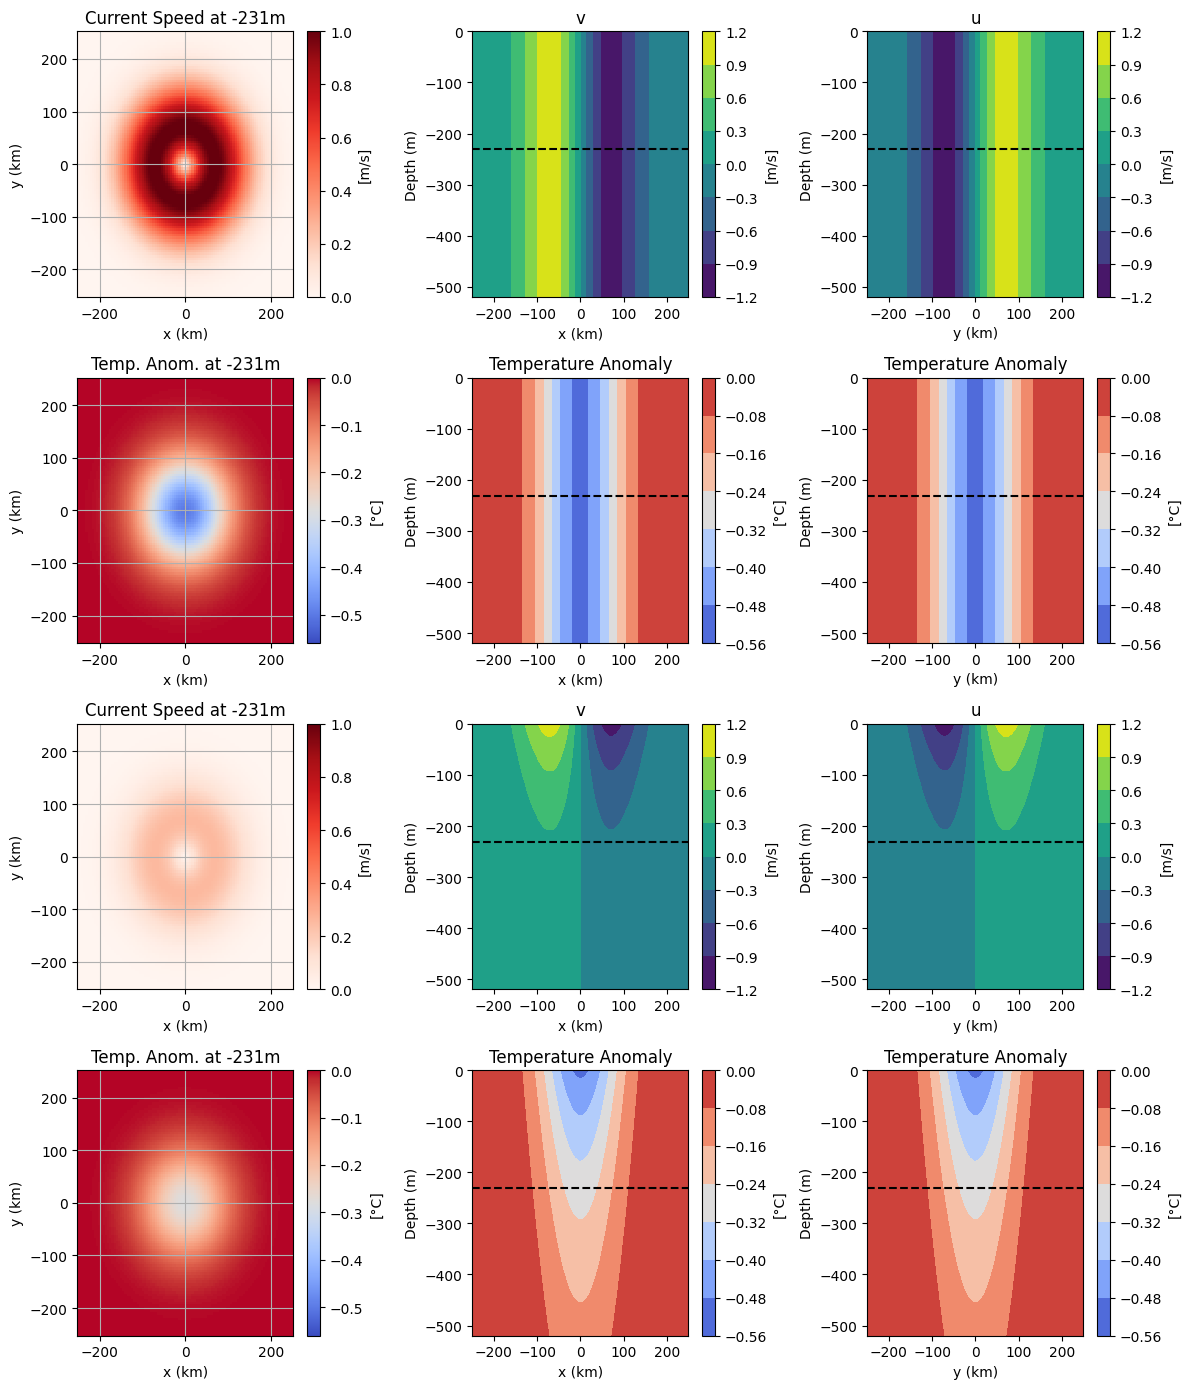

In [3]:
fig, axs = plt.subplots(4, 3, figsize=(12, 14))

e = 0
for H in [1000, 1000]:

    if e == 0:
        num_depth_layers = 10
        taper_depth = None
    else:
        num_depth_layers = 10
        taper_depth = 400
        
    U, V, sigma, T, CS, x, y, z = calculate_eddy(H=H, num_depth_layers=num_depth_layers, taper_depth=taper_depth)
    
    DEPTH_LVL = 4

    # Plot Current Speed
    c1 = axs[e+0,0].pcolor(x, y, CS[:,:,DEPTH_LVL].T, cmap='Reds', vmin=0, vmax=1)
    fig.colorbar(c1, ax=axs[e+0,0], label='[m/s]')
    axs[e+0,0].set_title('Current Speed at '+str(round(z[DEPTH_LVL]))+'m')
    axs[e+0,0].set_xlabel('x (km)')
    axs[e+0,0].set_ylabel('y (km)')
    axs[e+0,0].grid(True)
    
    # Plot v velocity
    contour_v = axs[e+0,1].contourf(y, z, V[:,V.shape[1]//2,:].T, cmap='viridis')
    fig.colorbar(contour_v, ax=axs[e+0,1], label='[m/s]')
    axs[e+0,1].plot([y[0],y[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
    axs[e+0,1].set_title('v')
    axs[e+0,1].set_xlabel('x (km)')
    axs[e+0,1].set_ylabel('Depth (m)')
    
    # Plot u velocity
    contour_u = axs[e+0,2].contourf(x, z, U[U.shape[0]//2,:,:].T, cmap='viridis')
    fig.colorbar(contour_u, ax=axs[e+0,2], label='[m/s]')
    axs[e+0,2].plot([x[0],x[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
    axs[e+0,2].set_title('u')
    axs[e+0,2].set_xlabel('y (km)')
    axs[e+0,2].set_ylabel('Depth (m)')
    
    # Plot Temperature for the current depth level
    c2 = axs[e+1,0].pcolor(x, y, T[:,:,DEPTH_LVL].T, cmap='coolwarm', vmin=-.56, vmax=0)
    fig.colorbar(c2, ax=axs[e+1,0], label='[°C]')
    axs[e+1,0].set_title('Temp. Anom. at '+str(round(z[DEPTH_LVL]))+'m')
    axs[e+1,0].set_xlabel('x (km)')
    axs[e+1,0].set_ylabel('y (km)')
    axs[e+1,0].grid(True)
    
    # Plot Temperature  at y = middle slice
    temp_y = axs[e+1,1].contourf(y, z, T[:,T.shape[1]//2,:].T, cmap='coolwarm')
    fig.colorbar(temp_y, ax=axs[e+1,1], label='[°C]')
    axs[e+1,1].plot([y[0],y[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
    axs[e+1,1].set_title('Temperature Anomaly')
    axs[e+1,1].set_xlabel('x (km)')
    axs[e+1,1].set_ylabel('Depth (m)')
    
    # Plot Temperature Anomaly at x = middle slice
    temp_x = axs[e+1,2].contourf(x, z, T[T.shape[0]//2,:,:].T, cmap='coolwarm')
    fig.colorbar(temp_x, ax=axs[e+1,2], label='[°C]')
    axs[e+1,2].plot([x[0],x[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
    axs[e+1,2].set_title('Temperature Anomaly')
    axs[e+1,2].set_xlabel('y (km)')
    axs[e+1,2].set_ylabel('Depth (m)')
    
    # fig.suptitle('Non-Tilt Model')
    e = 2

U, V, sigma, T, CS, x, y, z = calculate_eddy(dTdz=.005)
U_s, V_s, sigma_s, T_s, CS_s, x_s, y_s, z_s = calculate_eddy(dTdz=.005, H=800)
    
plt.tight_layout()
plt.show()


## Tilt

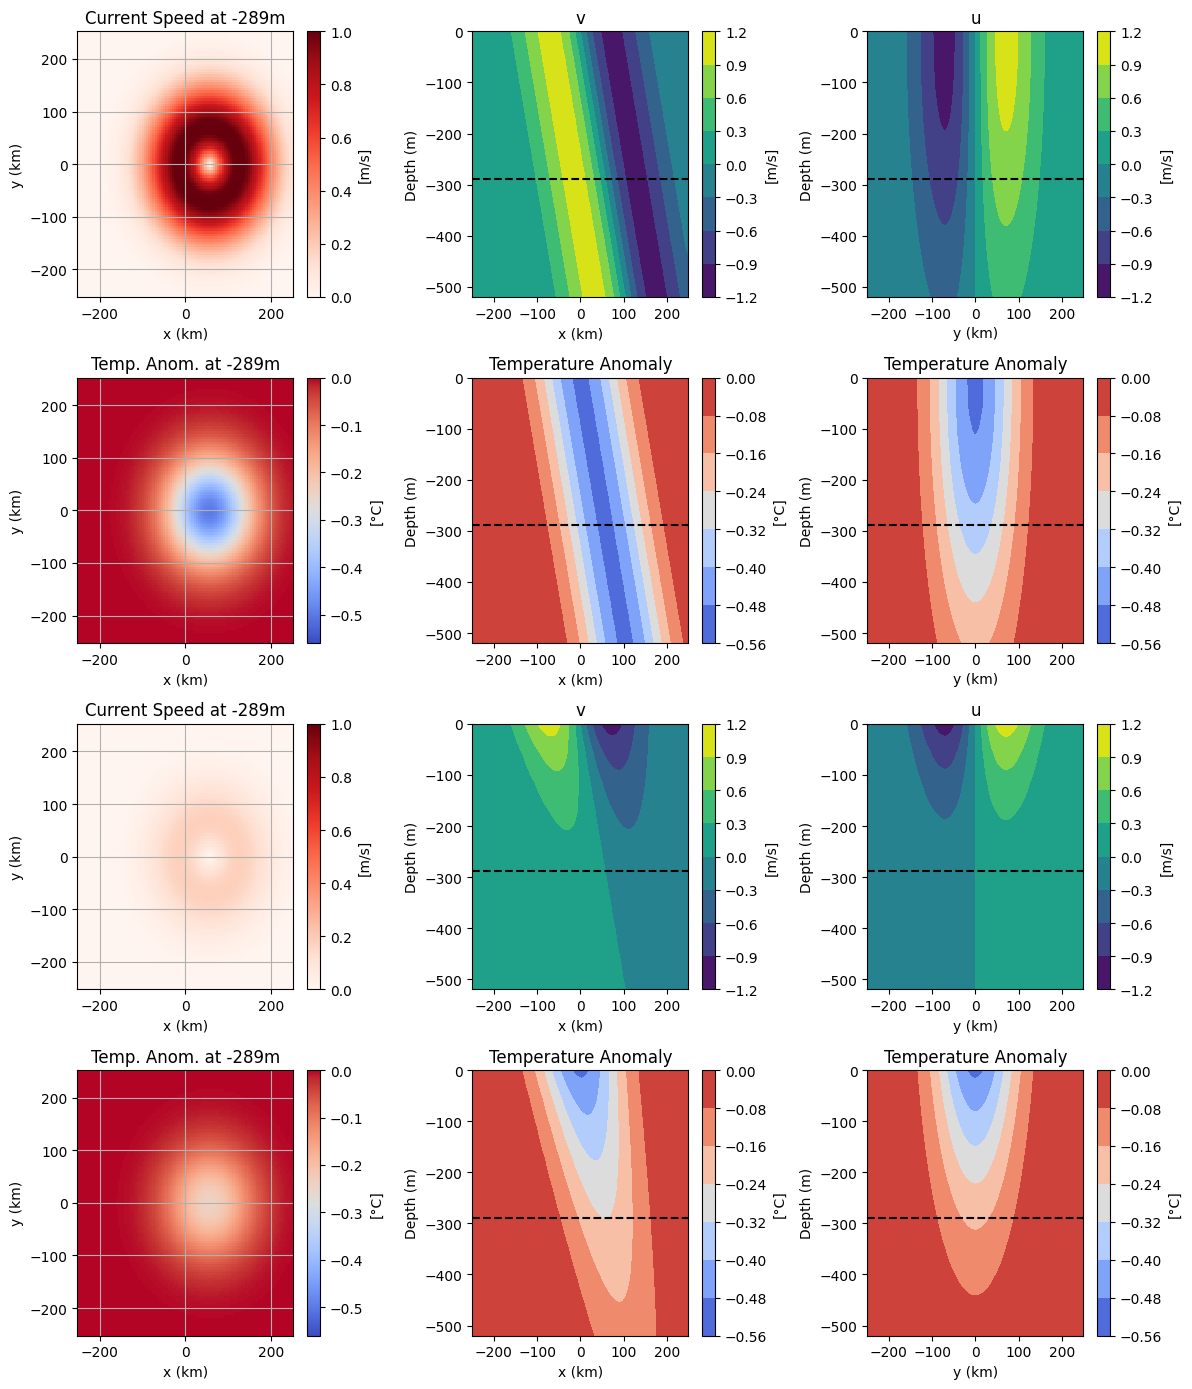

In [4]:
fig, axs = plt.subplots(4, 3, figsize=(12, 14))

e = 0
for H in [1000, 1000]:

    if e == 0:
        num_depth_layers = 10
        taper_depth = None
    else:
        num_depth_layers = 10
        taper_depth = 400
        
    U, V, sigma, T, CS, x, y, z = calculate_eddy(alpha_1=-200, H=H, num_depth_layers=num_depth_layers, taper_depth=taper_depth)
    
    DEPTH_LVL = 5

    # Plot Current Speed
    c1 = axs[e+0,0].pcolor(x, y, CS[:,:,DEPTH_LVL].T, cmap='Reds', vmin=0, vmax=1)
    fig.colorbar(c1, ax=axs[e+0,0], label='[m/s]')
    axs[e+0,0].set_title('Current Speed at '+str(round(z[DEPTH_LVL]))+'m')
    axs[e+0,0].set_xlabel('x (km)')
    axs[e+0,0].set_ylabel('y (km)')
    axs[e+0,0].grid(True)
    
    # Plot v velocity
    contour_v = axs[e+0,1].contourf(y, z, V[:,V.shape[1]//2,:].T, cmap='viridis')
    fig.colorbar(contour_v, ax=axs[e+0,1], label='[m/s]')
    axs[e+0,1].plot([y[0],y[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
    axs[e+0,1].set_title('v')
    axs[e+0,1].set_xlabel('x (km)')
    axs[e+0,1].set_ylabel('Depth (m)')
    
    # Plot u velocity
    contour_u = axs[e+0,2].contourf(x, z, U[U.shape[0]//2,:,:].T, cmap='viridis')
    fig.colorbar(contour_u, ax=axs[e+0,2], label='[m/s]')
    axs[e+0,2].plot([x[0],x[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
    axs[e+0,2].set_title('u')
    axs[e+0,2].set_xlabel('y (km)')
    axs[e+0,2].set_ylabel('Depth (m)')
    
    # Plot Temperature for the current depth level
    c2 = axs[e+1,0].pcolor(x, y, T[:,:,DEPTH_LVL].T, cmap='coolwarm', vmin=-.56,vmax=0)
    fig.colorbar(c2, ax=axs[e+1,0], label='[°C]')
    axs[e+1,0].set_title('Temp. Anom. at '+str(round(z[DEPTH_LVL]))+'m')
    axs[e+1,0].set_xlabel('x (km)')
    axs[e+1,0].set_ylabel('y (km)')
    axs[e+1,0].grid(True)
    
    # Plot Temperature  at y = middle slice
    temp_y = axs[e+1,1].contourf(y, z, T[:,T.shape[1]//2,:].T, cmap='coolwarm')
    fig.colorbar(temp_y, ax=axs[e+1,1], label='[°C]')
    axs[e+1,1].plot([y[0],y[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
    axs[e+1,1].set_title('Temperature Anomaly')
    axs[e+1,1].set_xlabel('x (km)')
    axs[e+1,1].set_ylabel('Depth (m)')
    
    # Plot Temperature Anomaly at x = middle slice
    temp_x = axs[e+1,2].contourf(x, z, T[T.shape[0]//2,:,:].T, cmap='coolwarm')
    fig.colorbar(temp_x, ax=axs[e+1,2], label='[°C]')
    axs[e+1,2].plot([x[0],x[-1]],[z[DEPTH_LVL],z[DEPTH_LVL]],'--',color='k')
    axs[e+1,2].set_title('Temperature Anomaly')
    axs[e+1,2].set_xlabel('y (km)')
    axs[e+1,2].set_ylabel('Depth (m)')
    
    # fig.suptitle('Non-Tilt Model')
    e = 2

U, V, sigma, T, CS, x, y, z = calculate_eddy(dTdz=.005)
U_s, V_s, sigma_s, T_s, CS_s, x_s, y_s, z_s = calculate_eddy(dTdz=.005, H=400)
    
plt.tight_layout()
plt.show()

In [5]:
U, V, sigma, T, CS, x, y, z = calculate_eddy(taper_depth=None)
U_tap, V_tap, sigma_tap, T_tap, CS_tap, x_tap, y_tap, z_tap = calculate_eddy(taper_depth=400)
U_tilt, V_tilt, sigma_tilt, T_tilt, CS_tilt, x_tilt, y_tilt, z_tilt = calculate_eddy(alpha_1=-200, taper_depth=None)
U_tilt_tap, V_tilt_tap, sigma_tilt_tap, T_tilt_tap, CS_tilt_tap, x_tilt_tap, y_tilt_tap, z_tilt_tap = calculate_eddy(alpha_1=-200, taper_depth=400)

## OW Isosurface

In [6]:
def compute_flow_directions(u, v):
    nan_mask = np.isnan(u) | np.isnan(v)
    direction_matrix = np.full(u.shape, np.nan)
    valid_mask = ~nan_mask
    u_valid, v_valid = u[valid_mask], v[valid_mask]
    
    if u_valid.size > 0:
        angles_degrees = np.degrees(np.arctan2(v_valid, u_valid)) % 360
        direction_matrix_valid = np.zeros(u_valid.shape, dtype=int)
        direction_matrix_valid[(angles_degrees >= 0) & (angles_degrees < 90)] = 1
        direction_matrix_valid[(angles_degrees >= 90) & (angles_degrees < 180)] = 2
        direction_matrix_valid[(angles_degrees >= 180) & (angles_degrees < 270)] = 3
        direction_matrix_valid[(angles_degrees >= 270) & (angles_degrees < 360)] = 4
        direction_matrix[valid_mask] = direction_matrix_valid

    return direction_matrix

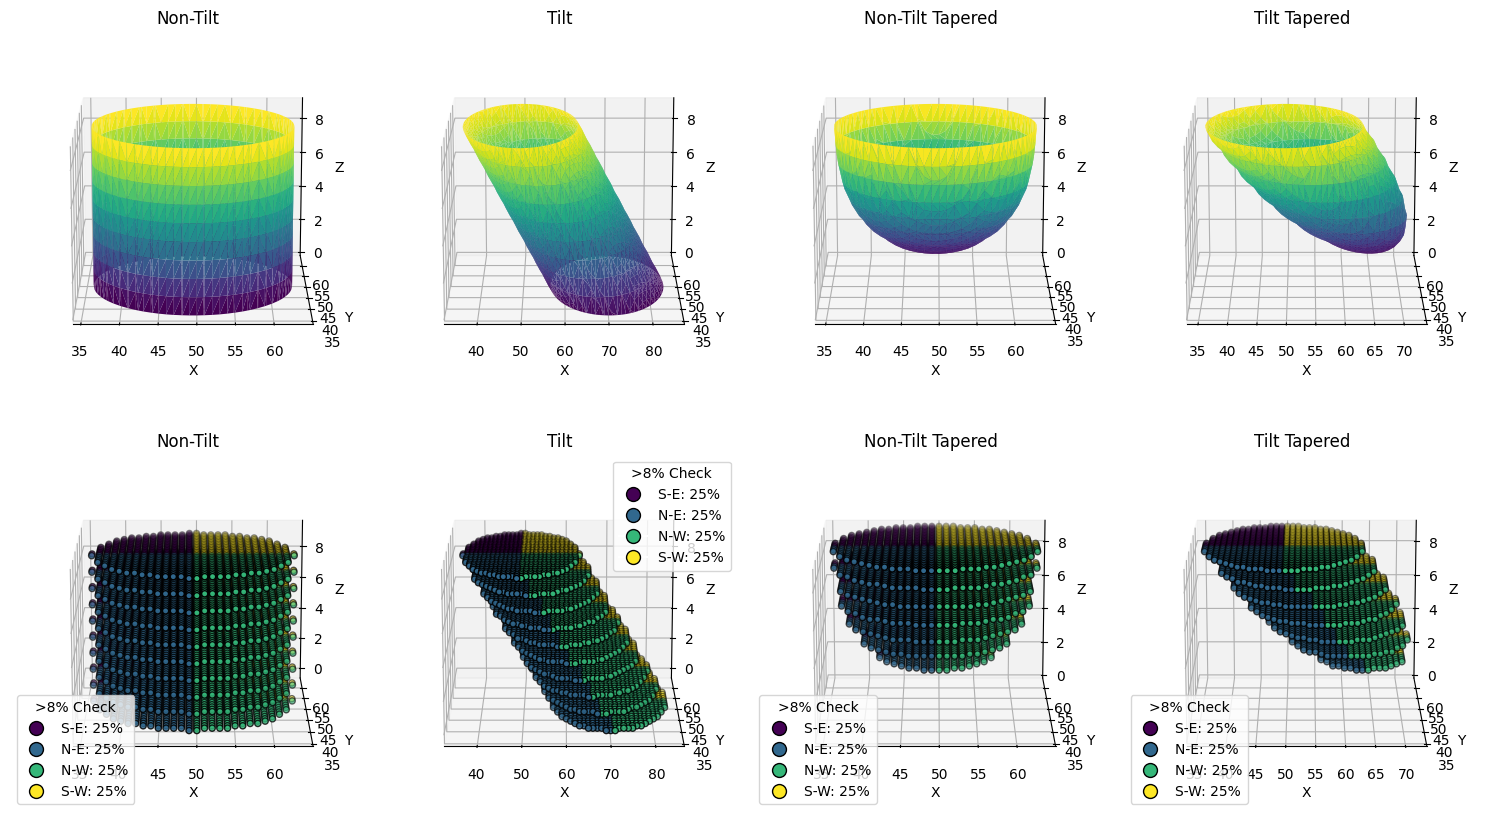

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

OW_THRESH = -.2

ow = calculate_okubo_weis(U, V, x[1]-x[0], y[1]-y[0])
ow = normalize_matrix(ow)

ow_tilt = calculate_okubo_weis(U_tilt, V_tilt, x_tilt[1]-x_tilt[0], y_tilt[1]-y_tilt[0])
ow_tilt = normalize_matrix(ow_tilt)

ow_tap = calculate_okubo_weis(U_tap, V_tap, x_tap[1]-x_tap[0], y_tap[1]-y_tap[0])
ow_tap = normalize_matrix(ow_tap)

ow_tilt_tap = calculate_okubo_weis(U_tilt_tap, V_tilt_tap, x_tilt_tap[1]-x_tilt_tap[0], y_tilt_tap[1]-y_tilt_tap[0])
ow_tilt_tap = normalize_matrix(ow_tilt_tap)

fig = plt.figure(figsize=(15, 9))

# Non-Tilt Isosurface
ax1 = fig.add_subplot(241, projection='3d')
verts, faces, _, _ = measure.marching_cubes(np.flip(ow, axis=2), OW_THRESH)
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='viridis', lw=1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Non-Tilt')
ax1.view_init(elev=15, azim=270)

# Tilt Isosurface
ax2 = fig.add_subplot(242, projection='3d')
verts_tilt, faces_tilt, _, _ = measure.marching_cubes(np.flip(ow_tilt, axis=2), OW_THRESH)
ax2.plot_trisurf(verts_tilt[:, 0], verts_tilt[:, 1], verts_tilt[:, 2], triangles=faces_tilt, cmap='viridis', lw=1)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Tilt')
ax2.view_init(elev=15, azim=270)

# Non-Tilt Tapered Isosurface
ax3 = fig.add_subplot(243, projection='3d')
verts_tap, faces_tap, _, _ = measure.marching_cubes(np.flip(ow_tap, axis=2), OW_THRESH)
ax3.plot_trisurf(verts_tap[:, 0], verts_tap[:, 1], verts_tap[:, 2], triangles=faces_tap, cmap='viridis', lw=1)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_title('Non-Tilt Tapered')
ax3.view_init(elev=15, azim=270)
ax3.set_zlim([0,9])

# Tilt Tapered Isosurface
ax4 = fig.add_subplot(244, projection='3d')
verts_tilt_tap, faces_tilt_tap, _, _ = measure.marching_cubes(np.flip(ow_tilt_tap, axis=2), OW_THRESH)
ax4.plot_trisurf(verts_tilt_tap[:, 0], verts_tilt_tap[:, 1], verts_tilt_tap[:, 2], triangles=faces_tilt_tap, cmap='viridis', lw=1)
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Z')
ax4.set_title('Tilt Tapered')
ax4.view_init(elev=15, azim=270)
ax4.set_zlim([0,9])

# Non-Tilt Direction Grouping
ax5 = fig.add_subplot(245, projection='3d')
emask = ow < OW_THRESH
u_mask = np.where(emask, U, np.nan)
v_mask = np.where(emask, V, np.nan)
dmat = np.flip(compute_flow_directions(u_mask, v_mask), axis=2)
i, j, k = np.where(~np.isnan(dmat))
values = dmat[~np.isnan(dmat)]
norm = Normalize(vmin=np.min(values), vmax=np.max(values))
sc = ax5.scatter(i, j, k, c=values, edgecolor='k')
labels = ['S-E: '+str(round(np.sum(values==1)/len(values)*100))+'%',
          'N-E: '+str(round(np.sum(values==2)/len(values)*100))+'%',
          'N-W: '+str(round(np.sum(values==3)/len(values)*100))+'%',
          'S-W: '+str(round(np.sum(values==4)/len(values)*100))+'%']
unique_values = np.unique(values)
cmap = plt.colormaps['viridis']
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(i)),
           markeredgecolor='k', markersize=10, label=labels[idx]) 
    for idx, i in enumerate(unique_values)
]
ax5.legend(handles=legend_elements, title=">8% Check")
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.set_zlabel('Z')
ax5.set_title('Non-Tilt')
ax5.view_init(elev=15, azim=270)

# Non-Tilt Direction Grouping
ax6 = fig.add_subplot(246, projection='3d')
emask = ow_tilt < OW_THRESH
u_tilt_mask = np.where(emask, U_tilt, np.nan)
v_tilt_mask = np.where(emask, V_tilt, np.nan)
dmat_tilt = np.flip(compute_flow_directions(u_tilt_mask, v_tilt_mask), axis=2)
i, j, k = np.where(~np.isnan(dmat_tilt))
values = dmat_tilt[~np.isnan(dmat_tilt)]
norm = Normalize(vmin=np.min(values), vmax=np.max(values))
sc = ax6.scatter(i, j, k, c=values, edgecolor='k')
labels = ['S-E: '+str(round(np.sum(values==1)/len(values)*100))+'%',
          'N-E: '+str(round(np.sum(values==2)/len(values)*100))+'%',
          'N-W: '+str(round(np.sum(values==3)/len(values)*100))+'%',
          'S-W: '+str(round(np.sum(values==4)/len(values)*100))+'%']
unique_values = np.unique(values)
cmap = plt.colormaps['viridis']
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(i)),
           markeredgecolor='k', markersize=10, label=labels[idx]) 
    for idx, i in enumerate(unique_values)
]
ax6.legend(handles=legend_elements, title=">8% Check")
ax6.set_xlabel('X')
ax6.set_ylabel('Y')
ax6.set_zlabel('Z')
ax6.set_title('Tilt')
ax6.view_init(elev=15, azim=270)

# Non-Tilt Tapered Direction Grouping
ax7 = fig.add_subplot(247, projection='3d')
emask = ow_tap < OW_THRESH
u_tap_mask = np.where(emask, U_tap, np.nan)
v_tap_mask = np.where(emask, V_tap, np.nan)
dmat_tap = np.flip(compute_flow_directions(u_tap_mask, v_tap_mask), axis=2)
i, j, k = np.where(~np.isnan(dmat_tap))
values = dmat_tap[~np.isnan(dmat_tap)]
norm = Normalize(vmin=np.min(values), vmax=np.max(values))
sc = ax7.scatter(i, j, k, c=values, edgecolor='k')
labels = ['S-E: '+str(round(np.sum(values==1)/len(values)*100))+'%',
          'N-E: '+str(round(np.sum(values==2)/len(values)*100))+'%',
          'N-W: '+str(round(np.sum(values==3)/len(values)*100))+'%',
          'S-W: '+str(round(np.sum(values==4)/len(values)*100))+'%']
unique_values = np.unique(values)
cmap = plt.colormaps['viridis']
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(i)),
           markeredgecolor='k', markersize=10, label=labels[idx]) 
    for idx, i in enumerate(unique_values)
]
ax7.legend(handles=legend_elements, title=">8% Check")
ax7.set_xlabel('X')
ax7.set_ylabel('Y')
ax7.set_zlabel('Z')
ax7.set_title('Non-Tilt Tapered')
ax7.view_init(elev=15, azim=270)
ax7.set_zlim([0,9])

# Tilt Tapered Direction Grouping
ax8 = fig.add_subplot(248, projection='3d')
emask = ow_tilt_tap < OW_THRESH
u_tilt_tap_mask = np.where(emask, U_tilt_tap, np.nan)
v_tilt_tap_mask = np.where(emask, V_tilt_tap, np.nan)
dmat_tilt_tap = np.flip(compute_flow_directions(u_tilt_tap_mask, v_tilt_tap_mask), axis=2)
i, j, k = np.where(~np.isnan(dmat_tilt_tap))
values = dmat_tilt_tap[~np.isnan(dmat_tilt_tap)]
norm = Normalize(vmin=np.min(values), vmax=np.max(values))
sc = ax8.scatter(i, j, k, c=values, edgecolor='k')
labels = ['S-E: '+str(round(np.sum(values==1)/len(values)*100))+'%',
          'N-E: '+str(round(np.sum(values==2)/len(values)*100))+'%',
          'N-W: '+str(round(np.sum(values==3)/len(values)*100))+'%',
          'S-W: '+str(round(np.sum(values==4)/len(values)*100))+'%']
unique_values = np.unique(values)
cmap = plt.colormaps['viridis']
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(i)),
           markeredgecolor='k', markersize=10, label=labels[idx]) 
    for idx, i in enumerate(unique_values)
]
ax8.legend(handles=legend_elements, title=">8% Check")
ax8.set_xlabel('X')
ax8.set_ylabel('Y')
ax8.set_zlabel('Z')
ax8.set_title('Tilt Tapered')
ax8.view_init(elev=15, azim=270)
ax8.set_zlim([0,9])

plt.tight_layout()
plt.show()

## SSIM 

In [8]:
def make_ssim_matrix(df):
    xs, ys, values = df.Right, df.Up, df.Correlation
    ssim_mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
    for i in np.unique(xs):
        for j in np.unique(ys):
            ssim_mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]
    return ssim_mat

### Current Speed

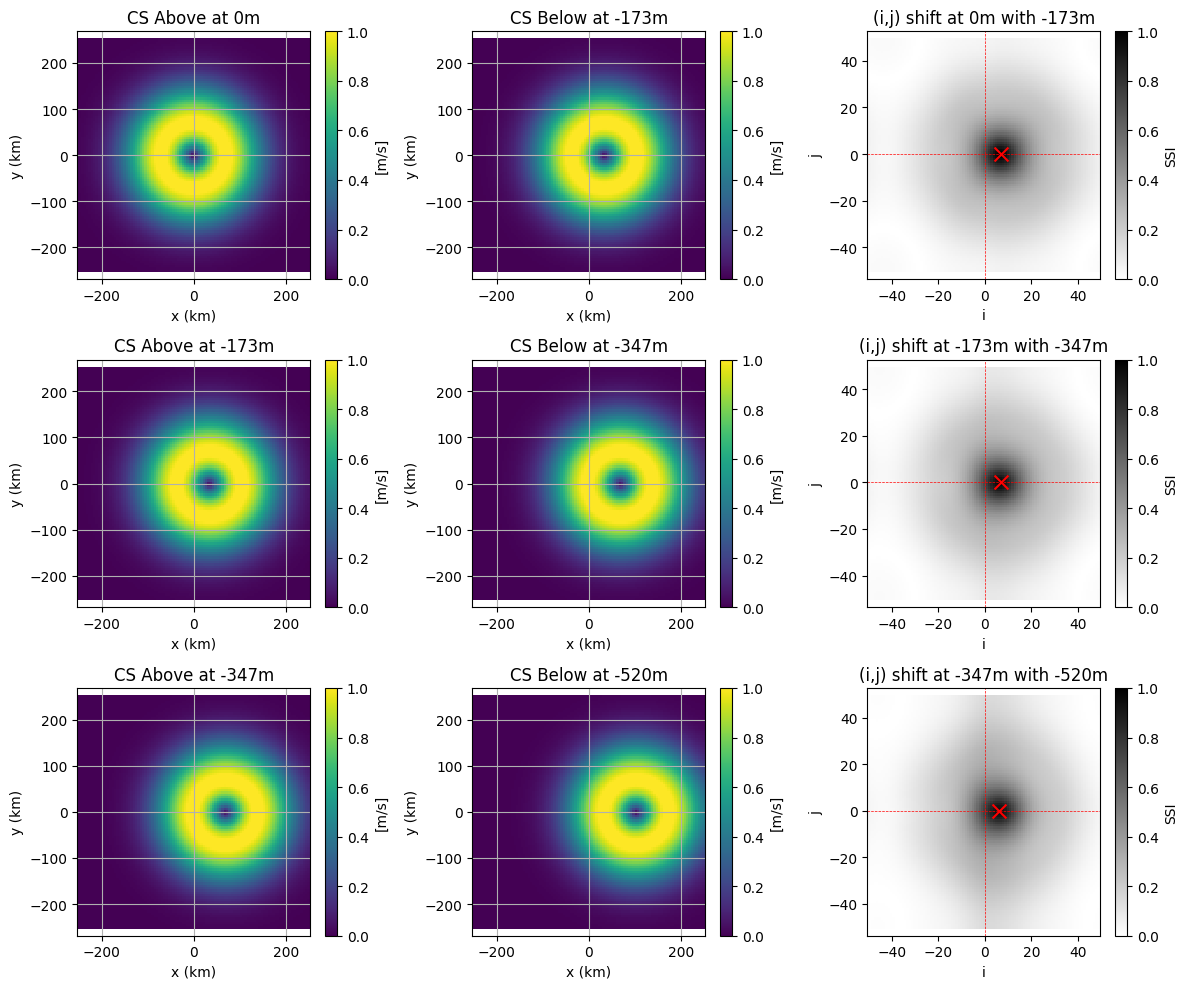

In [9]:
fig, ax = plt.subplots(U_tilt.shape[2]//3, 3, figsize=(12, 10))

img_row = 0
for depth_lvl in range(U_tilt.shape[2]):

    if depth_lvl % 3 == 0 and depth_lvl != len(z_tilt) - 1:
    
        Data_abv = CS_tilt[:, :, depth_lvl].T
        Data_blw = CS_tilt[:, :, depth_lvl + 3].T
        
        df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
        ssim_mat = make_ssim_matrix(df)
        
        # First subplot
        contour1 = ax[img_row,0].pcolor(x_tilt, y_tilt, Data_abv, vmin=0, vmax=1)
        ax[img_row,0].set_title('CS Above at '+str(round(z[depth_lvl]))+'m')
        ax[img_row,0].grid(True)
        ax[img_row,0].set_xlabel('x (km)')
        ax[img_row,0].set_ylabel('y (km)')
        ax[img_row,0].axis('equal')
        
        # Second subplot
        contour2 = ax[img_row,1].pcolor(x_tilt, y_tilt, Data_blw, vmin=0, vmax=1)
        ax[img_row,1].set_title('CS Below at '+str(round(z[depth_lvl+3]))+'m')
        ax[img_row,1].grid(True)
        ax[img_row,1].set_xlabel('x (km)')
        ax[img_row,1].set_ylabel('y (km)')
        ax[img_row,1].axis('equal')
        
        # Third subplot
        contour3 = ax[img_row,2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r', vmin=0, vmax=1)
        ax[img_row,2].set_title('(i,j) shift at '+str(round(z[depth_lvl]))+'m with '+str(round(z[depth_lvl + 3]))+'m')
        ax[img_row,2].scatter(iR, iU, marker='x', color='r', s=100)
        ax[img_row,2].axvline(x=0, color='r', linestyle='--', linewidth=.5)
        ax[img_row,2].axhline(y=0, color='r', linestyle='--', linewidth=.5)
        ax[img_row,2].set_xlabel('i')
        ax[img_row,2].set_ylabel('j')
        ax[img_row,2].axis('equal')

        cbar1 = fig.colorbar(contour1, ax=ax[img_row,0])
        cbar1.set_label('[m/s]')
        cbar2 = fig.colorbar(contour2, ax=ax[img_row,1])
        cbar2.set_label('[m/s]')
        cbar3 = fig.colorbar(contour3, ax=ax[img_row,2])
        cbar3.set_label('SSI')
    
        img_row += 1
    
# fig.suptitle('Tilt Model')

plt.tight_layout()
plt.show()

The above image needs to move to the right, to match the below image

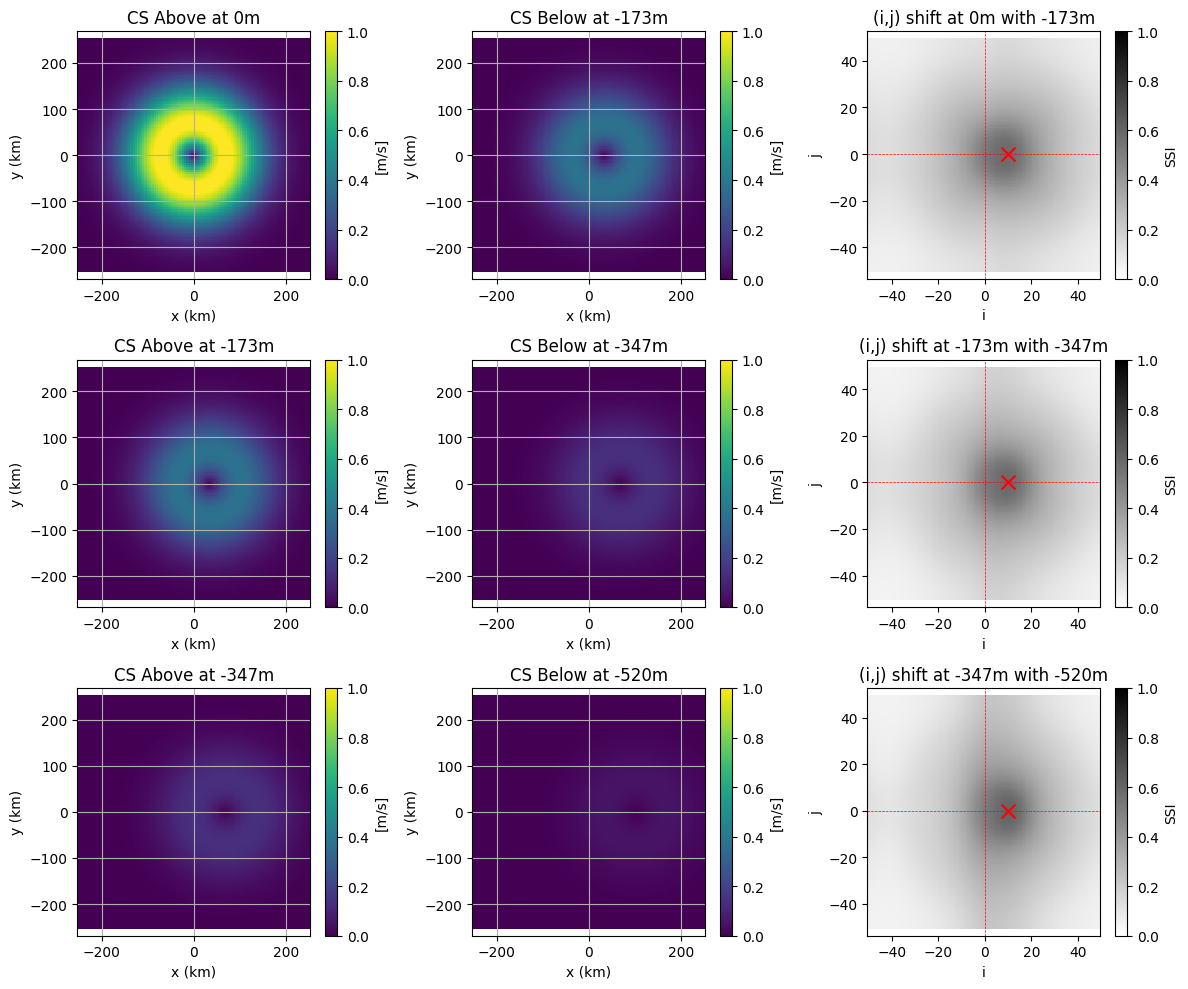

In [10]:
fig, ax = plt.subplots(U_tilt_tap.shape[2]//3, 3, figsize=(12, 10))

img_row = 0
for depth_lvl in range(U_tilt_tap.shape[2]):

    if depth_lvl % 3 == 0 and depth_lvl != len(z_tilt_tap) - 1:
    
        Data_abv = CS_tilt_tap[:, :, depth_lvl].T
        Data_blw = CS_tilt_tap[:, :, depth_lvl + 3].T
        
        df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
        ssim_mat = make_ssim_matrix(df)
        
        # First subplot
        contour1 = ax[img_row,0].pcolor(x_tilt, y_tilt, Data_abv, vmin=0, vmax=1)
        ax[img_row,0].set_title('CS Above at '+str(round(z[depth_lvl]))+'m')
        ax[img_row,0].grid(True)
        ax[img_row,0].set_xlabel('x (km)')
        ax[img_row,0].set_ylabel('y (km)')
        ax[img_row,0].axis('equal')
        
        # Second subplot
        contour2 = ax[img_row,1].pcolor(x_tilt, y_tilt, Data_blw, vmin=0, vmax=1)
        ax[img_row,1].set_title('CS Below at '+str(round(z[depth_lvl+3]))+'m')
        ax[img_row,1].grid(True)
        ax[img_row,1].set_xlabel('x (km)')
        ax[img_row,1].set_ylabel('y (km)')
        ax[img_row,1].axis('equal')
        
        # Third subplot
        contour3 = ax[img_row,2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r', vmin=0, vmax=1)
        ax[img_row,2].set_title('(i,j) shift at '+str(round(z[depth_lvl]))+'m with '+str(round(z[depth_lvl + 3]))+'m')
        ax[img_row,2].scatter(iR, iU, marker='x', color='r', s=100)
        ax[img_row,2].axvline(x=0, color='r', linestyle='--', linewidth=.5)
        ax[img_row,2].axhline(y=0, color='r', linestyle='--', linewidth=.5)
        ax[img_row,2].set_xlabel('i')
        ax[img_row,2].set_ylabel('j')
        ax[img_row,2].axis('equal')

        cbar1 = fig.colorbar(contour1, ax=ax[img_row,0])
        cbar1.set_label('[m/s]')
        cbar2 = fig.colorbar(contour2, ax=ax[img_row,1])
        cbar2.set_label('[m/s]')
        cbar3 = fig.colorbar(contour3, ax=ax[img_row,2])
        cbar3.set_label('SSI')
    
        img_row += 1
    
# fig.suptitle('Tilt Model')

plt.tight_layout()
plt.show()

### Temperature Anomaly

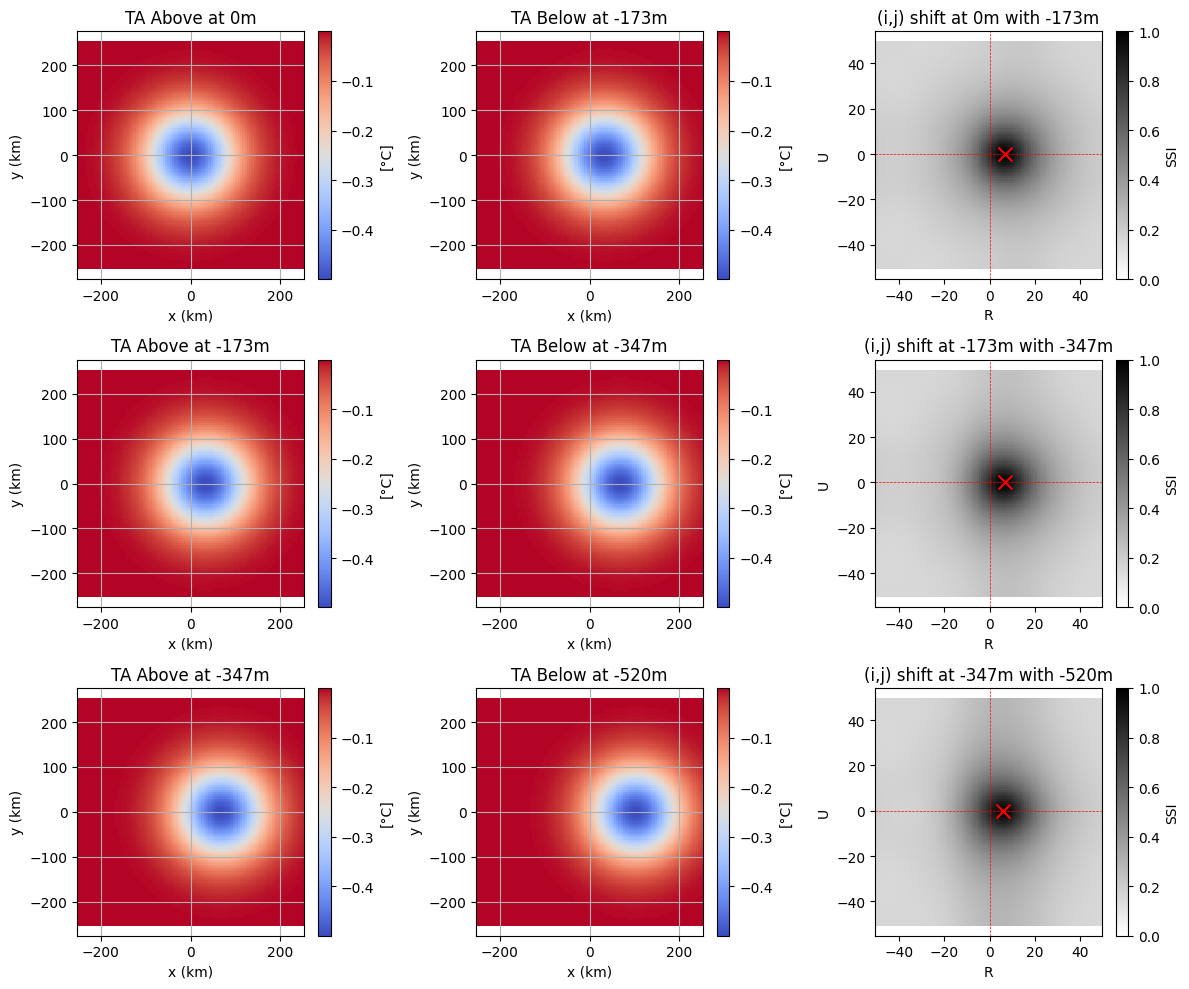

In [11]:
fig, ax = plt.subplots(U_tilt.shape[2]//3, 3, figsize=(12, 10))

img_row = 0
for depth_lvl in range(U_tilt.shape[2]):

    if depth_lvl % 3 == 0 and depth_lvl != len(z_tilt) - 1:
    
        Data_abv = T_tilt[:, :, depth_lvl].T
        Data_blw = T_tilt[:, :, depth_lvl + 3].T
        
        df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
        ssim_mat = make_ssim_matrix(df)
        
        # First subplot
        contour1 = ax[img_row,0].pcolor(x_tilt, y_tilt, Data_abv, cmap='coolwarm')
        ax[img_row,0].set_title('TA Above at '+str(round(z[depth_lvl]))+'m')
        ax[img_row,0].grid(True)
        ax[img_row,0].set_xlabel('x (km)')
        ax[img_row,0].set_ylabel('y (km)')
        ax[img_row,0].axis('equal')
        
        # Second subplot
        contour2 = ax[img_row,1].pcolor(x_tilt, y_tilt, Data_blw, cmap='coolwarm')
        ax[img_row,1].set_title('TA Below at '+str(round(z[depth_lvl+3]))+'m')
        ax[img_row,1].grid(True)
        ax[img_row,1].set_xlabel('x (km)')
        ax[img_row,1].set_ylabel('y (km)')
        ax[img_row,1].axis('equal')
        
        # Third subplot
        contour3 = ax[img_row,2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r', vmin=0, vmax=1)
        ax[img_row,2].set_title('(i,j) shift at '+str(round(z[depth_lvl]))+'m with '+str(round(z[depth_lvl + 3]))+'m')
        ax[img_row,2].scatter(iR, iU, marker='x', color='r', s=100)
        ax[img_row,2].axvline(x=0, color='r', linestyle='--', linewidth=.5)
        ax[img_row,2].axhline(y=0, color='r', linestyle='--', linewidth=.5)
        ax[img_row,2].set_xlabel('R')
        ax[img_row,2].set_ylabel('U')
        ax[img_row,2].axis('equal')
        
        cbar1 = fig.colorbar(contour1, ax=ax[img_row,0])
        cbar1.set_label('[°C]')
        cbar2 = fig.colorbar(contour2, ax=ax[img_row,1])
        cbar2.set_label('[°C]')
        cbar3 = fig.colorbar(contour3, ax=ax[img_row,2])
        cbar3.set_label('SSI')
    
        img_row += 1
    
# fig.suptitle('Tilt Model')

plt.tight_layout()
plt.show()

Not optimal results for Temperature. Why is the overall SSI so large?

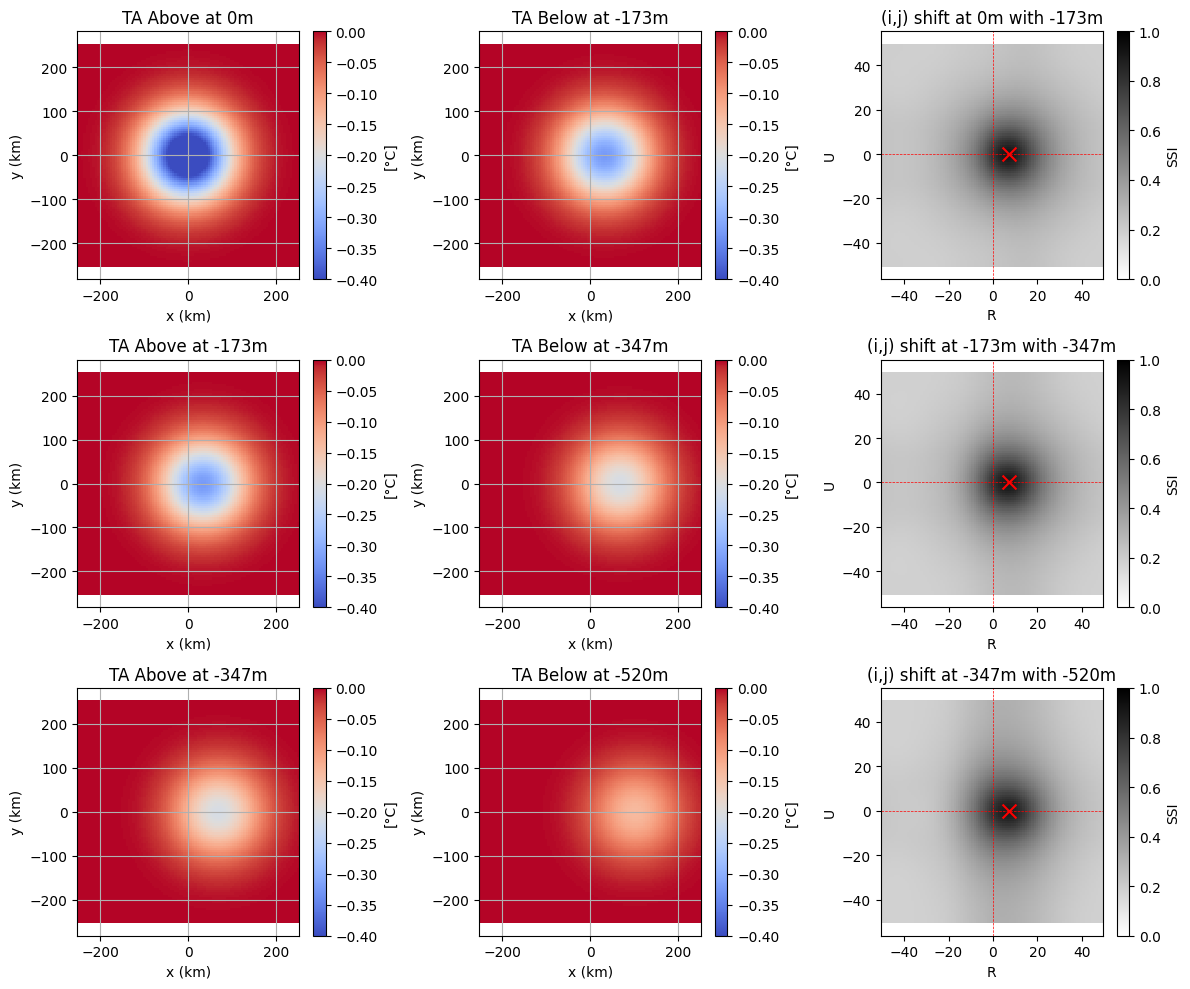

In [12]:
fig, ax = plt.subplots(U_tilt.shape[2]//3, 3, figsize=(12, 10))

img_row = 0
for depth_lvl in range(U_tilt.shape[2]):

    if depth_lvl % 3 == 0 and depth_lvl != len(z_tilt) - 1:
    
        Data_abv = T_tilt_tap[:, :, depth_lvl].T
        Data_blw = T_tilt_tap[:, :, depth_lvl + 3].T
        
        df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
        ssim_mat = make_ssim_matrix(df)
        
        # First subplot
        contour1 = ax[img_row,0].pcolor(x_tilt_tap, y_tilt_tap, Data_abv, cmap='coolwarm', vmin=-.4, vmax=0)
        ax[img_row,0].set_title('TA Above at '+str(round(z[depth_lvl]))+'m')
        ax[img_row,0].grid(True)
        ax[img_row,0].set_xlabel('x (km)')
        ax[img_row,0].set_ylabel('y (km)')
        ax[img_row,0].axis('equal')
        
        # Second subplot
        contour2 = ax[img_row,1].pcolor(x_tilt_tap, y_tilt_tap, Data_blw, cmap='coolwarm', vmin=-.4, vmax=0)
        ax[img_row,1].set_title('TA Below at '+str(round(z[depth_lvl+3]))+'m')
        ax[img_row,1].grid(True)
        ax[img_row,1].set_xlabel('x (km)')
        ax[img_row,1].set_ylabel('y (km)')
        ax[img_row,1].axis('equal')
        
        # Third subplot
        contour3 = ax[img_row,2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r', vmin=0, vmax=1)
        ax[img_row,2].set_title('(i,j) shift at '+str(round(z[depth_lvl]))+'m with '+str(round(z_tap[depth_lvl + 3]))+'m')
        ax[img_row,2].scatter(iR, iU, marker='x', color='r', s=100)
        ax[img_row,2].axvline(x=0, color='r', linestyle='--', linewidth=.5)
        ax[img_row,2].axhline(y=0, color='r', linestyle='--', linewidth=.5)
        ax[img_row,2].set_xlabel('R')
        ax[img_row,2].set_ylabel('U')
        ax[img_row,2].axis('equal')
        
        cbar1 = fig.colorbar(contour1, ax=ax[img_row,0])
        cbar1.set_label('[°C]')
        cbar2 = fig.colorbar(contour2, ax=ax[img_row,1])
        cbar2.set_label('[°C]')
        cbar3 = fig.colorbar(contour3, ax=ax[img_row,2])
        cbar3.set_label('SSI')
    
        img_row += 1
    
# fig.suptitle('Tilt Model')

plt.tight_layout()
plt.show()

## Results

In [13]:
##### CS #####
Us_CS, Rs_CS = [0], [0]
for depth_lvl in range(U_tilt.shape[2]-1):
    Data_abv = CS_tilt[:, :, depth_lvl].T
    Data_blw = CS_tilt[:, :, depth_lvl + 1].T
    _, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    Us_CS.append(int(iU)+Us_CS[-1])
    Rs_CS.append(int(iR)+Rs_CS[-1])
mx, my = len(x_tilt)//2, len(y_tilt)//2
xc_CS, yc_CS, zc_CS = x_tilt[mx + np.array(Rs_CS)], y_tilt[my + np.array(Us_CS)], z_tilt

Us_CS_tap, Rs_CS_tap = [0], [0]
for depth_lvl in range(U_tilt_tap.shape[2]-1):
    Data_abv = CS_tilt_tap[:, :, depth_lvl].T
    Data_blw = CS_tilt_tap[:, :, depth_lvl + 1].T
    _, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    Us_CS_tap.append(int(iU)+Us_CS_tap[-1])
    Rs_CS_tap.append(int(iR)+Rs_CS_tap[-1])
mx, my = len(x_tilt_tap)//2, len(y_tilt_tap)//2
xc_CS_tap, yc_CS_tap, zc_CS_tap = x_tilt_tap[mx + np.array(Rs_CS_tap)], y_tilt_tap[my + np.array(Us_CS_tap)], z_tilt_tap

In [14]:
##### Temp #####
Us_T, Rs_T = [0], [0]
for depth_lvl in range(U_tilt.shape[2]-1):
    Data_abv = T_tilt[:, :, depth_lvl].T
    Data_blw = T_tilt[:, :, depth_lvl + 1].T
    _, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    Us_T.append(int(iU)+Us_T[-1])
    Rs_T.append(int(iR)+Rs_T[-1])
mx, my = len(x_tilt)//2, len(y_tilt)//2
xc_T, yc_T, zc_T = x_tilt[mx + np.array(Rs_T)], y_tilt[my + np.array(Us_T)], z_tilt

Us_T_tap, Rs_T_tap = [0], [0]
for depth_lvl in range(U_tilt_tap.shape[2]-1):
    Data_abv = T_tilt_tap[:, :, depth_lvl].T
    Data_blw = T_tilt_tap[:, :, depth_lvl + 1].T
    _, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    Us_T_tap.append(int(iU)+Us_T_tap[-1])
    Rs_T_tap.append(int(iR)+Rs_T_tap[-1])
mx, my = len(x_tilt_tap)//2, len(y_tilt_tap)//2
xc_T_tap, yc_T_tap, zc_T_tap = x_tilt_tap[mx + np.array(Rs_T_tap)], y_tilt_tap[my + np.array(Us_T_tap)], z_tilt_tap

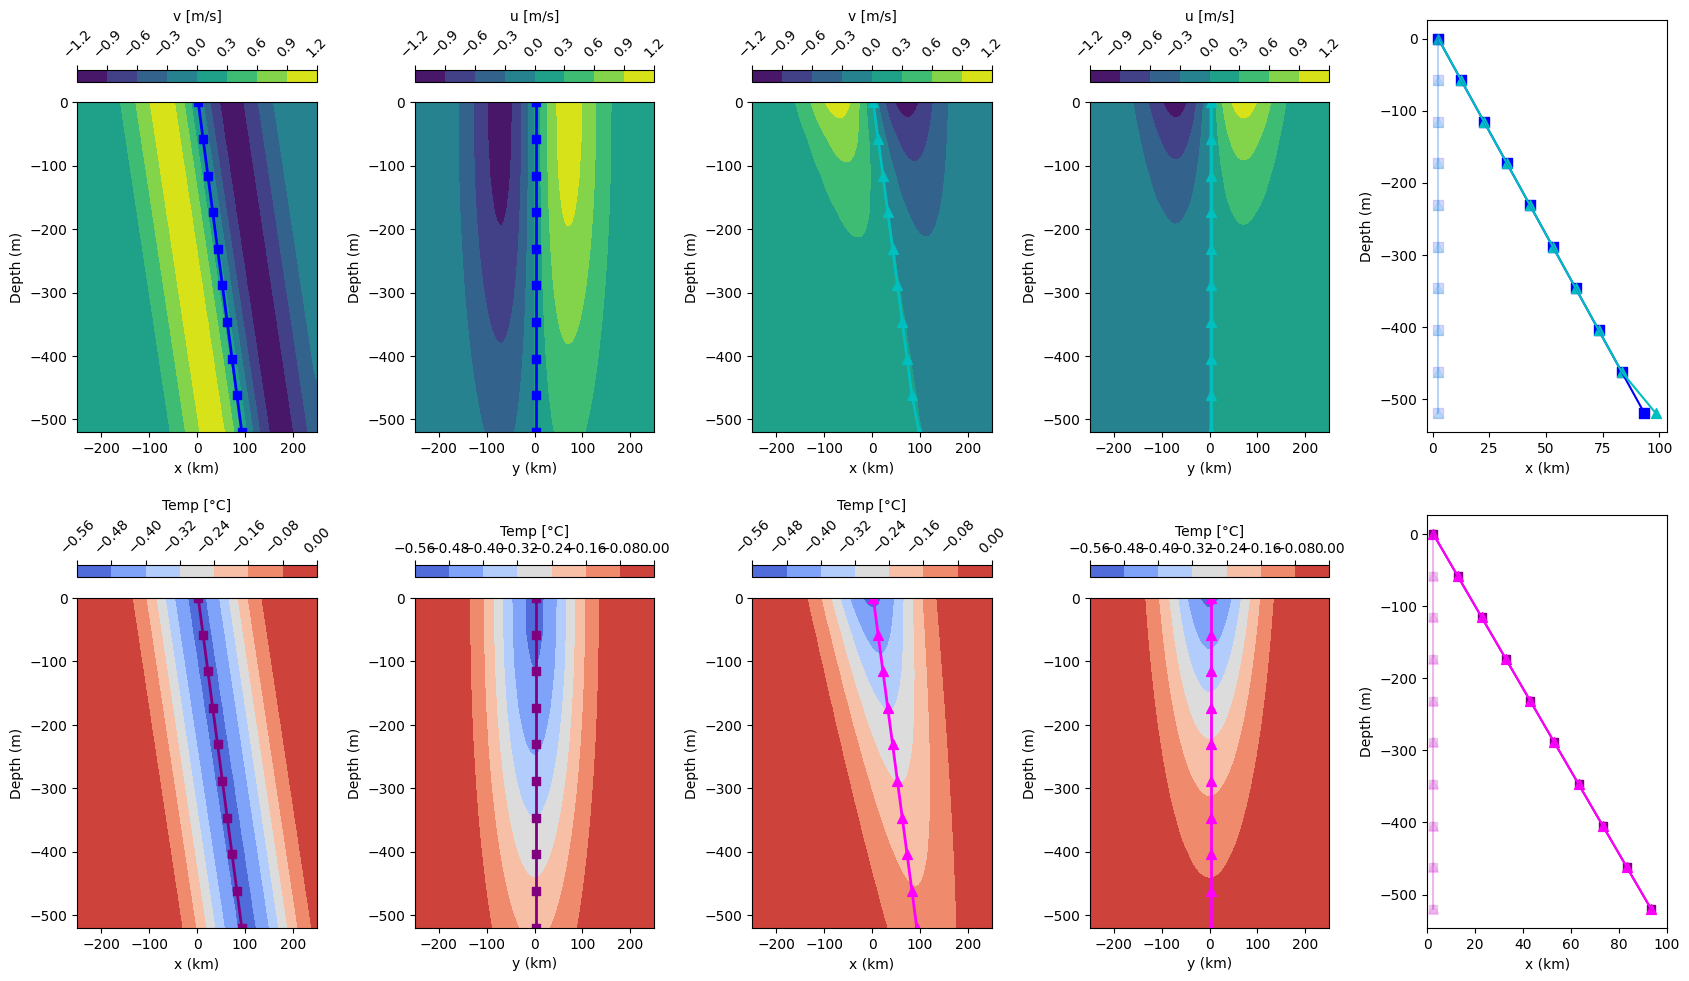

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(17, 10))

# Plot v velocity
contour_v = axs[0,0].contourf(y_tilt, z_tilt, V_tilt[:,V_tilt.shape[1]//2,:].T, cmap='viridis')
cbar = fig.colorbar(contour_v, ax=axs[0,0], label='v [m/s]', orientation='horizontal', location='top')
cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
axs[0,0].plot(xc_CS, zc_CS, '-', linewidth=2, color='b')
axs[0,0].scatter(xc_CS, zc_CS, color='b', s=35, marker='s')
axs[0,0].set_xlabel('x (km)')
axs[0,0].set_ylabel('Depth (m)')

# Plot u velocity
contour_u = axs[0,1].contourf(x_tilt, z_tilt, U_tilt[U_tilt.shape[0]//2,:,:].T, cmap='viridis')
cbar = fig.colorbar(contour_u, ax=axs[0,1], label='u [m/s]', orientation='horizontal', location='top')
cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
axs[0,1].plot(yc_CS, zc_CS, '-', linewidth=2, color='b')
axs[0,1].scatter(yc_CS, zc_CS, color='b', s=35, marker='s')
axs[0,1].set_xlabel('y (km)')
axs[0,1].set_ylabel('Depth (m)')

# Plot v velocity
contour_v_tap = axs[0,2].contourf(y_tilt_tap, z_tilt_tap, V_tilt_tap[:,V_tilt_tap.shape[1]//2,:].T, cmap='viridis')
cbar = fig.colorbar(contour_v_tap, ax=axs[0,2], label='v [m/s]', orientation='horizontal', location='top')
cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
axs[0,2].plot(xc_CS_tap, zc_CS_tap, '-', linewidth=2, color='c')
axs[0,2].scatter(xc_CS_tap, zc_CS_tap, color='c', s=50, marker='^')
axs[0,2].set_xlabel('x (km)')
axs[0,2].set_ylabel('Depth (m)')

# Plot u velocity
contour_u_tap = axs[0,3].contourf(x_tilt_tap, z_tilt_tap, U_tilt_tap[U_tilt_tap.shape[0]//2,:,:].T, cmap='viridis')
cbar = fig.colorbar(contour_u_tap, ax=axs[0,3], label='u [m/s]', orientation='horizontal', location='top')
cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
axs[0,3].plot(yc_CS_tap, zc_CS_tap, '-', linewidth=2, color='c')
axs[0,3].scatter(yc_CS_tap, zc_CS_tap, color='c', s=50, marker='^')
axs[0,3].set_xlabel('y (km)')
axs[0,3].set_ylabel('Depth (m)')

# Results
axs[0,4].plot(xc_CS, zc_CS, color='b')
axs[0,4].scatter(xc_CS, zc_CS, marker='s', color='b', s=50)
axs[0,4].plot(xc_CS_tap, zc_CS_tap, color='c')
axs[0,4].scatter(xc_CS_tap, zc_CS_tap, marker='^', color='c', s=50)

axs[0,4].plot(yc_CS, zc_CS, color='b', alpha=.15)
axs[0,4].scatter(yc_CS, zc_CS, color='b', marker='s', s=50, alpha=.15)
axs[0,4].plot(yc_CS_tap, zc_CS_tap, color='c', alpha=.15)
axs[0,4].scatter(yc_CS_tap, zc_CS_tap, color='c', marker='^', s=50, alpha=.15)

axs[0,4].set_xlabel('x (km)')
axs[0,4].set_ylabel('Depth (m)')

# Plot Temperature at y = middle slice
temp_y = axs[1,0].contourf(y_tilt, z_tilt, T_tilt[:,T_tilt.shape[1]//2,:].T, cmap='coolwarm')
cbar = fig.colorbar(temp_y, ax=axs[1,0], label='Temp [°C]', orientation='horizontal', location='top')
cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
axs[1,0].plot(xc_T, zc_T, '-', linewidth=2, color='purple')
axs[1,0].scatter(xc_T, zc_T, color='purple', s=35, marker='s')
axs[1,0].set_xlabel('x (km)')
axs[1,0].set_ylabel('Depth (m)')

# Plot Temperature at x = middle slice
temp_x = axs[1,1].contourf(x_tilt, z_tilt, T_tilt[T_tilt.shape[0]//2,:,:].T, cmap='coolwarm')
cabr = fig.colorbar(temp_x, ax=axs[1,1], label='Temp [°C]', orientation='horizontal', location='top')
cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
axs[1,1].plot(yc_T, zc_T, '-', linewidth=2, color='purple')
axs[1,1].scatter(yc_T, zc_T, color='purple', s=35, marker='s')
axs[1,1].set_xlabel('y (km)')
axs[1,1].set_ylabel('Depth (m)')

# Plot Temperature at y = middle slice
temp_y_tap = axs[1,2].contourf(y_tilt_tap, z_tilt_tap, T_tilt_tap[:,T_tilt_tap.shape[1]//2,:].T, cmap='coolwarm')
cbar = fig.colorbar(temp_y_tap, ax=axs[1,2], label='Temp [°C]', orientation='horizontal', location='top')
cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
axs[1,2].plot(xc_T_tap, zc_T_tap, '-', linewidth=2, color='magenta')
axs[1,2].scatter(xc_T_tap, zc_T_tap, color='magenta', s=50, marker='^')
axs[1,2].set_xlabel('x (km)')
axs[1,2].set_ylabel('Depth (m)')

# Plot Temperature at x = middle slice
temp_x_tap = axs[1,3].contourf(x_tilt_tap, z_tilt_tap, T_tilt_tap[T_tilt_tap.shape[0]//2,:,:].T, cmap='coolwarm')
cabr = fig.colorbar(temp_x_tap, ax=axs[1,3], label='Temp [°C]', orientation='horizontal', location='top')
cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
axs[1,3].plot(yc_T_tap, zc_T_tap, '-', linewidth=2, color='magenta')
axs[1,3].scatter(yc_T_tap, zc_T_tap, color='magenta', s=50, marker='^')
axs[1,3].set_xlabel('y (km)')
axs[1,3].set_ylabel('Depth (m)')


# Results
axs[1,4].plot(xc_T, zc_T, color='purple')
axs[1,4].scatter(xc_T, zc_T, color='purple', s=35, marker='s')
axs[1,4].plot(xc_T_tap, zc_T_tap, color='magenta')
axs[1,4].scatter(xc_T_tap, zc_T_tap, color='magenta', s=50, marker='^')

axs[1,4].plot(yc_T_tap, zc_T_tap, color='purple', alpha=.15)
axs[1,4].scatter(yc_T_tap, zc_T_tap, color='purple', s=35, alpha=.15, marker='s')
axs[1,4].plot(yc_T_tap, zc_T_tap, color='magenta', alpha=.15)
axs[1,4].scatter(yc_T_tap, zc_T_tap, color='magenta', s=50, alpha=.15, marker='^')

axs[1,4].set_xlabel('x (km)')
axs[1,4].set_ylabel('Depth (m)')
axs[1,4].set_xlim([0,100])

# fig.suptitle('Tilt Model With SSIM Results')

plt.tight_layout()
plt.show()

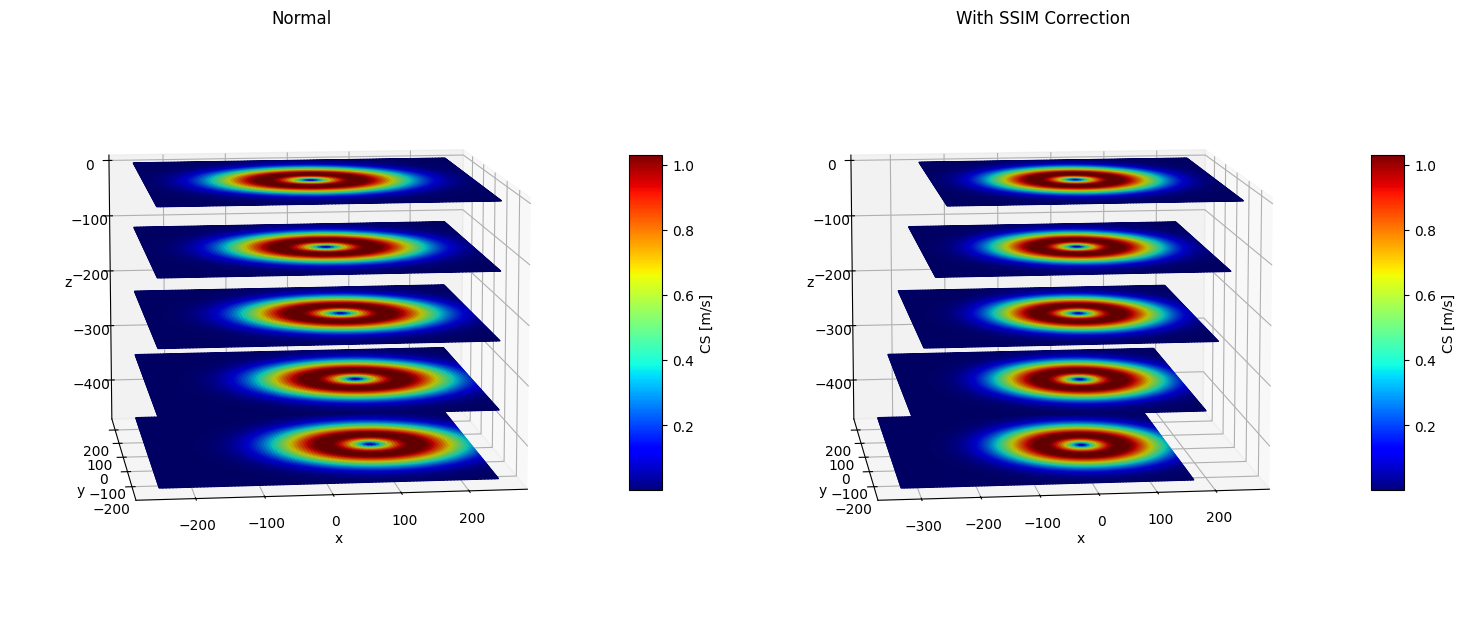

In [16]:
from matplotlib import cm
from matplotlib.colors import Normalize

dx = x_tilt[2] - x_tilt[1]

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(15, 7))

norm = Normalize(vmin=CS_tilt.min(), vmax=CS_tilt.max())
cmap = cm.jet

# First subplot
ax1 = fig.add_subplot(121, projection='3d')

for depth_lvl in range(CS_tilt.shape[-1]):
    if depth_lvl % 2 == 0:
        X, Y = np.meshgrid(x_tilt, y_tilt)
        surface1 = ax1.plot_surface(X, Y, z_tilt[depth_lvl] * np.ones_like(X), 
                         rstride=1, cstride=1, facecolors=plt.cm.jet(CS_tilt[:, :, depth_lvl].T))

ax1.view_init(elev=10, azim=-97)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Normal')

mappable1 = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable1.set_array(CS_tilt)
cbar1 = fig.colorbar(mappable1, ax=ax1, shrink=0.5, aspect=10)
cbar1.set_label('CS [m/s]')

# Second subplot
ax2 = fig.add_subplot(122, projection='3d')

for depth_lvl in range(CS_tilt.shape[-1]):
    if depth_lvl % 2 == 0:
        X, Y = np.meshgrid(x_tilt, y_tilt)
        surface2 = ax2.plot_surface(X - Rs_CS[depth_lvl] * dx, Y - Us_CS[depth_lvl] * dx, z_tilt[depth_lvl] * np.ones_like(X), 
                 rstride=1, cstride=1, facecolors=plt.cm.jet(CS_tilt[:, :, depth_lvl].T))

ax2.view_init(elev=10, azim=-97)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('With SSIM Correction')

mappable2 = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable2.set_array(CS_tilt)
cbar2 = fig.colorbar(mappable2, ax=ax2, shrink=0.5, aspect=10)
cbar2.set_label('CS [m/s]')

plt.tight_layout()
plt.show()


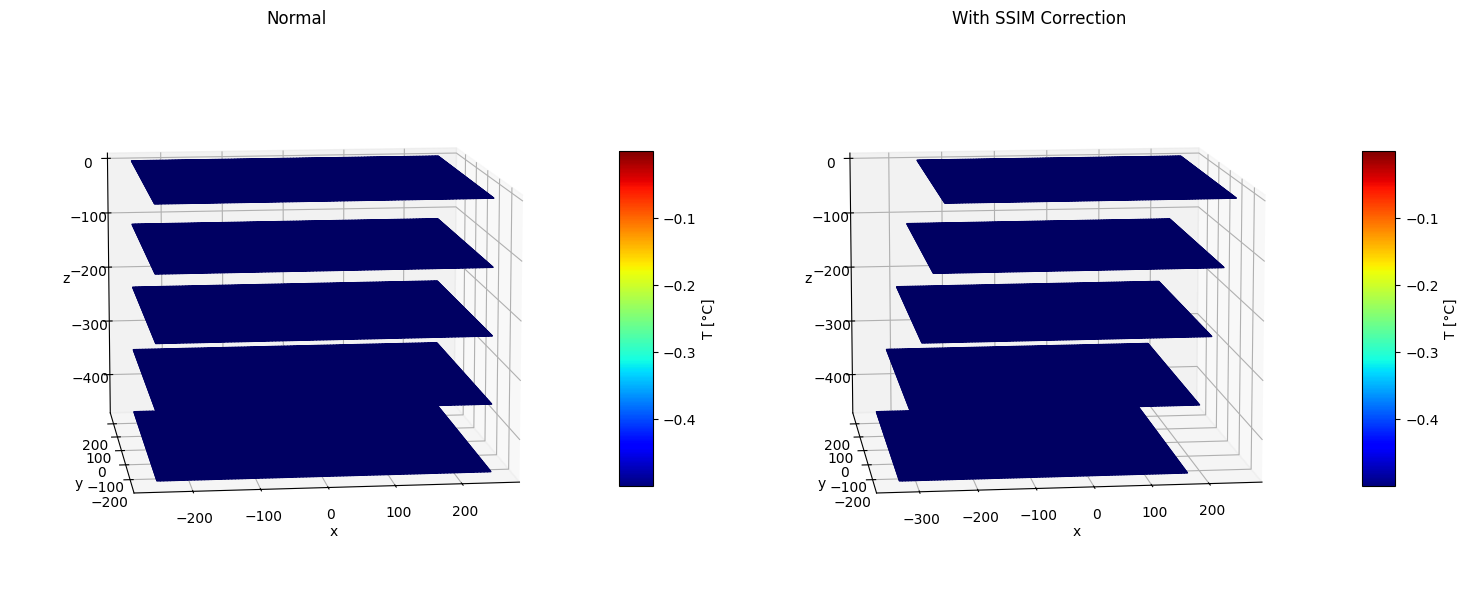

In [17]:
from matplotlib import cm
from matplotlib.colors import Normalize

dx = x_tilt[2] - x_tilt[1]

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(15, 7))

norm = Normalize(vmin=T_tilt.min(), vmax=T_tilt.max())
cmap = cm.jet

# First subplot
ax1 = fig.add_subplot(121, projection='3d')

for depth_lvl in range(T_tilt.shape[-1]):
    if depth_lvl % 2 == 0:
        X, Y = np.meshgrid(x_tilt, y_tilt)
        surface1 = ax1.plot_surface(X, Y, z_tilt[depth_lvl] * np.ones_like(X), 
                         rstride=1, cstride=1, facecolors=plt.cm.jet(T_tilt[:, :, depth_lvl].T))

ax1.view_init(elev=10, azim=-97)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Normal')

mappable1 = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable1.set_array(T_tilt)
cbar1 = fig.colorbar(mappable1, ax=ax1, shrink=0.5, aspect=10)
cbar1.set_label('T [°C]')

# Second subplot
ax2 = fig.add_subplot(122, projection='3d')

for depth_lvl in range(T_tilt.shape[-1]):
    if depth_lvl % 2 == 0:
        X, Y = np.meshgrid(x_tilt, y_tilt)
        surface2 = ax2.plot_surface(X - Rs_T[depth_lvl] * dx, Y - Us_T[depth_lvl] * dx, z_tilt[depth_lvl] * np.ones_like(X), 
                 rstride=1, cstride=1, facecolors=plt.cm.jet(T_tilt[:, :, depth_lvl].T))

ax2.view_init(elev=10, azim=-97)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('With SSIM Correction')

mappable2 = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable2.set_array(T_tilt)
cbar2 = fig.colorbar(mappable2, ax=ax2, shrink=0.5, aspect=10)
cbar2.set_label('T [°C]')

plt.tight_layout()
plt.show()

# Nencioli + MOCA

## Nencioli 

In [18]:
def nenc_crit_1(v, a):
    rows, cols = v.shape
    criteria_mask = np.zeros_like(v, dtype=bool)
    for j in range(a, cols - a):
        wrk = v[:, j]
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        for ii in indx:  
            if v[ii - a, j] * v[ii + a, j] < 0:  
                if abs(v[ii - a, j]) > abs(v[ii, j]) and abs(v[ii + a, j]) > abs(v[ii, j]):
                    criteria_mask[ii, j] = True
    return criteria_mask

def nenc_crit_2(u, a):
    rows, cols = u.shape
    criteria_mask = np.zeros_like(u, dtype=bool)
    for i in range(a, rows - a): 
        wrk = u[i, :]
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        for jj in indx:  
            if u[i, jj - a] * u[i, jj + a] < 0:  
                if abs(u[i, jj - a]) > abs(u[i, jj]) and abs(u[i, jj + a]) > abs(u[i, jj]):
                    criteria_mask[i, jj] = True
    return criteria_mask

def nenc_crit_3(u, v, b):
    velocity_magnitude = np.sqrt(u**2 + v**2)
    rows, cols = velocity_magnitude.shape
    local_minimum_mask = np.zeros_like(velocity_magnitude, dtype=bool)
    for i in range(b, rows - b):  
        for j in range(b, cols - b):  
            current_magnitude = velocity_magnitude[i, j]
            neighborhood = velocity_magnitude[i-b:i+b+1, j-b:j+b+1]
            if current_magnitude <= np.min(neighborhood):
                local_minimum_mask[i, j] = True
                # Set the 8 neighboring points to True, with boundary checks
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < rows and 0 <= nj < cols:  # Ensure neighbors are within bounds
                            local_minimum_mask[ni, nj] = True    
    return local_minimum_mask
    
def nenc_crit_4(u, v, a):

    # Assuming u and v are your 2D matrices of velocities
    rows, cols = u.shape

    # Compute the velocity angle at each point
    angles = np.arctan2(v, u)  # Get the angle in radians
    angles = np.degrees(angles)  # Convert to degrees
    angles = (angles + 360) % 360  # Normalize to the range [0, 360]
    angles = angles.T
    
    # Create a mask to store points that meet the rotational consistency criterion
    rotation_mask = np.zeros_like(angles, dtype=bool)
    
    # Function to determine the quadrant of an angle
    def quadrant(angles):
        quadrants = []
        for angle in angles:
            if 0 <= angle < 90:
                quadrants.append(1)  # First quadrant: east to north
            elif 90 <= angle < 180:
                quadrants.append(2)  # Second quadrant: north to west
            elif 180 <= angle < 270:
                quadrants.append(3)  # Third quadrant: west to south
            elif 270 <= angle < 360:
                quadrants.append(4)  # Fourth quadrant: south to east
            else:
                quadrants.append(None)  # For angles outside the 0-360 range
        return quadrants
    
    # Function to check if two quadrants are adjacent
    def adjacent_quadrants(q1, q2):
        return abs(q1 - q2) == 1 or abs(q1 - q2) == 3  # Wrap-around (1 and 4 are adjacent)
        
    # Loop through each point (avoid the edges by 'a' grid points)
    for i in range(a, rows - a):
        for j in range(a, cols - a):
  
            box_angles = []
            box_angles.extend(angles[i-a:i+a+1,j+a])
            box_angles.extend(np.flip(angles[i+a,j-a:j+a+1]))
            box_angles.extend(np.flip(angles[i-a:i+a+1,j-a]))
            box_angles.extend(angles[i-a,j-a:j+a+1])
            box_quadrants = quadrant(box_angles)

            consistent_rotation = True
            for current_quad, next_quad in zip(box_quadrants, box_quadrants[1:]):
                if current_quad != next_quad and not adjacent_quadrants(current_quad, next_quad):
                    consistent_rotation = False
                    break

            if consistent_rotation:
                rotation_mask[i, j] = True

    return rotation_mask

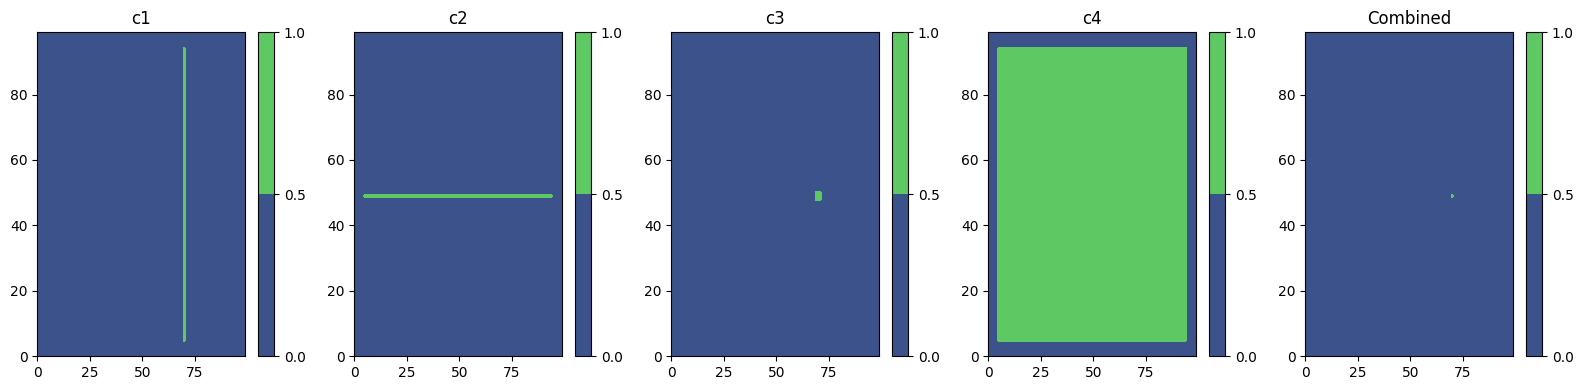

In [151]:
a = 5
b = 5
# for depth_lvl in range(U_tilt.shape[2]):
DEPTH_LVL = 9

u = U_tilt[:, :, DEPTH_LVL]
v = V_tilt[:, :, DEPTH_LVL]

c1 = nenc_crit_1(v, a)
c2 = nenc_crit_2(u, a)
c3 = nenc_crit_3(u, v, b)
c4 = nenc_crit_4(u, v, a)

combined = np.logical_and(np.logical_and(np.logical_and(c1, c2), c3), c4)
ic, jc = np.where(combined)
ic, jc = int(ic[0]), int(jc[0])  # Get the first occurrence

# Create a figure and 5 subplots arranged horizontally
fig, axs = plt.subplots(1, 5, figsize=(16, 4))  # Adjust figsize as needed

# Create each contour plot on the respective axis
contour1 = axs[0].contourf(c1.T)
axs[0].set_title('c1')
plt.colorbar(contour1, ax=axs[0])  # Add colorbar to each subplot

contour2 = axs[1].contourf(c2.T)
axs[1].set_title('c2')
plt.colorbar(contour2, ax=axs[1])

contour3 = axs[2].contourf(c3.T)
axs[2].set_title('c3')
plt.colorbar(contour3, ax=axs[2])

contour4 = axs[3].contourf(c4.T)
axs[3].set_title('c4')
plt.colorbar(contour4, ax=axs[3])

# Calculate the logical AND and create the last subplot

contour5 = axs[4].contourf(combined.T)
axs[4].set_title('Combined')
plt.colorbar(contour5, ax=axs[4])

# Adjust layout
plt.tight_layout()
plt.show()


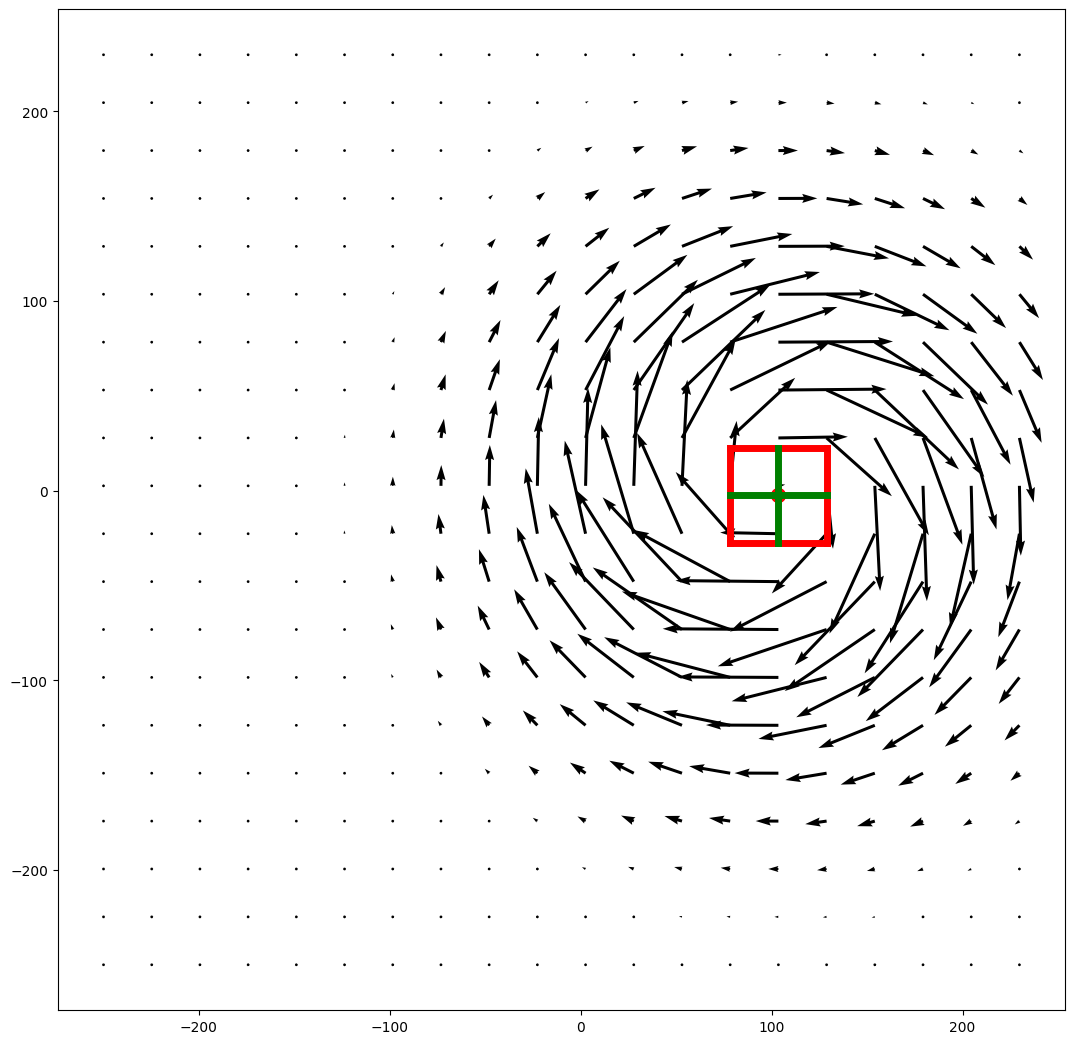

In [152]:
plt.figure(figsize=(13,13))
spacing = 5
plt.quiver(x_tilt[::spacing], y_tilt[::spacing], U_tilt[::spacing,::spacing,DEPTH_LVL].T, V_tilt[::spacing,::spacing,DEPTH_LVL].T)

# Perimeter
plt.plot(x_tilt[ic-b:ic+b+1], [y_tilt[jc+b]] * (2 * b + 1), 'r', linewidth=5)
plt.plot(x_tilt[ic-b:ic+b+1], [y_tilt[jc-b]] * (2 * b + 1), 'r', linewidth=5)
plt.plot([x_tilt[ic-b]] * (2 * b + 1), y_tilt[jc-b:jc+b+1], 'r', linewidth=5)
plt.plot([x_tilt[ic+b]] * (2 * b + 1), y_tilt[jc-b:jc+b+1], 'r', linewidth=5)

plt.plot(x_tilt[ic-a:ic+a+1], [y_tilt[jc]] * (2 * a + 1), 'g', linewidth=5)
plt.plot([x_tilt[ic]] * (2 * a + 1), y_tilt[jc-a:jc+a+1], 'g', linewidth=5)

plt.scatter(x_tilt[ic], y_tilt[jc], color='r', s=100)

In [21]:
a = 5
b = 3

W, L, D = U_tilt.shape

ics, jcs = [], []
depth_dics3 = {}
for depth_lvl in range(D):

    u = U_tilt[:, :, depth_lvl]
    v = V_tilt[:, :, depth_lvl]
    
    c1 = nenc_crit_1(v, a)
    c2 = nenc_crit_2(u, a)
    c3 = nenc_crit_3(u, v, b)
    c4 = nenc_crit_4(u, v, a)

    combined = np.logical_and(np.logical_and(np.logical_and(c1, c2), c3), c4)
    ic, jc = np.where(combined)
    ics.append(ic)
    jcs.append(jc)

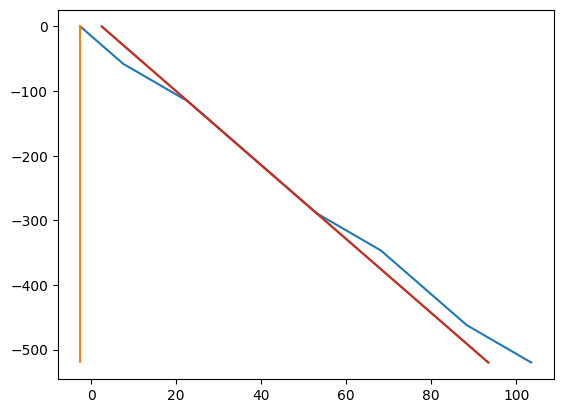

In [22]:
plt.plot(x[ics],z_tilt)
plt.plot(y[jcs],z_tilt)

plt.plot(xc_T, z_tilt)
plt.plot(xc_CS, z_tilt)

## MOCA

In [204]:
def polynomial_fit_with_error(x, y, degree=1):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]
    if degree not in [0, 1]:
        raise ValueError("Degree must be 0 or 1.")
    coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
    y_fit = np.polyval(coefficients, x)
    residuals = y - y_fit
    std_err_coeffs = np.sqrt(np.diag(cov))
    ss_total = np.sum((y - np.mean(y))**2)
    ss_residuals = np.sum(residuals**2)
    r_squared = 1 - (ss_residuals / ss_total)
    return coefficients, std_err_coeffs, r_squared

def haversine_distance(lat1, lon1, bearing, distance):
    R = 6371000
    lat1, lon1, bearing = map(math.radians, [lat1, lon1, bearing])

    lat2 = math.asin(math.sin(lat1) * math.cos(distance / R) +
                     math.cos(lat1) * math.sin(distance / R) * math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(distance / R) * math.cos(lat1),
                             math.cos(distance / R) - math.sin(lat1) * math.sin(lat2))

    return math.degrees(lat2), math.degrees(lon2)

def true_bearing(x, y):
    angle_radians = math.atan2(y, x)
    angle_degrees = math.degrees(angle_radians)
    bearing = (90 - angle_degrees) % 360
    return bearing

def is_pos_def(Q):
    eigenvalues = np.linalg.eigvals(Q)
    return np.all(eigenvalues > 0)

def find_increasing_magnitude_sublist(lst, ic, tolerance=0):

    min_radial_dist = 3
    
    # Initialize sublist and index list with the center element
    sublist = [lst[ic]]
    indices = [ic]
    
    # Move left and check if magnitude increases with tolerance, at least 3 indices
    count_left = 0
    for i in range(ic - 1, -1, -1):
        if count_left < min_radial_dist:
            sublist.insert(0, lst[i])
            indices.insert(0, i)
            count_left += 1
        elif abs(lst[i]) >= abs(sublist[0]) - tolerance:
            sublist.insert(0, lst[i])
            indices.insert(0, i)
        else:
            break
    
    # Move right and check if magnitude increases with tolerance, at least 3 indices
    count_right = 0
    for i in range(ic + 1, len(lst)):
        if count_right < min_radial_dist:
            sublist.append(lst[i])
            indices.append(i)
            count_right += 1
        elif abs(lst[i]) >= abs(sublist[-1]) - tolerance:
            sublist.append(lst[i])
            indices.append(i)
        else:
            break
    
    return np.array(sublist), indices



In [216]:
from scipy.signal import argrelextrema

depth_dics_MOCA = {}
for depth_lvl in range(U_tilt.shape[-1]):

    u = U_tilt[:, :, depth_lvl]
    v = V_tilt[:, :, depth_lvl]

    u1 = U_tilt[:, nenc_jc[depth_lvl], depth_lvl].squeeze()
    v1 = V_tilt[:, nenc_jc[depth_lvl], depth_lvl].squeeze()

    u2 = U_tilt[nenc_ic[depth_lvl], :, depth_lvl].squeeze()
    v2 = V_tilt[nenc_ic[depth_lvl], :, depth_lvl].squeeze()

    u2, u_ind = find_increasing_magnitude_sublist(u2, nenc_jc[depth_lvl])
    v2 = v2[u_ind]

    yy = (np.array(u_ind) - nenc_jc[depth_lvl]) * (y_tilt[1] - y_tilt[0])

    v1, v_ind = find_increasing_magnitude_sublist(v1, nenc_ic[depth_lvl])
    u1 = u1[v_ind]
    xx = (np.array(v_ind) - nenc_ic[depth_lvl]) * (x_tilt[1] - x_tilt[0])
    
    As, dAs, r2A = polynomial_fit_with_error(xx, u1, degree=1)
    A1, A0 = As
    Bs, dBs, r2B = polynomial_fit_with_error(xx, v1, degree=1)
    B1, B0 = Bs
    Cs, dCs, r2C = polynomial_fit_with_error(yy, u2, degree=1)
    C1, C0 = Cs
    Ds, DAs, r2D = polynomial_fit_with_error(yy, v2, degree=1)
    D1, D0 = Ds
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    Q = np.array([[q11, q12], [q12, q22]])
    if is_pos_def(Q) or is_pos_def(-Q):
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      

        xc += x_tilt[nenc_ic[depth_lvl]]
        yc += y_tilt[nenc_jc[depth_lvl]]

    else:
        xc = yc = np.nan
    depth_dics_MOCA[f'Depth{depth_lvl}'] = {
        'dfx': pd.DataFrame({'x': xx + x_tilt[nenc_ic[depth_lvl]], 'y': [y_tilt[nenc_jc[depth_lvl]]] * len(xx), 'u1': u1, 'v1': v1}),
        'dfy': pd.DataFrame({'y': yy + y_tilt[nenc_jc[depth_lvl]], 'x': [x_tilt[nenc_ic[depth_lvl]]] * len(yy), 'u2': u2, 'v2': v2}),
        'q11': q11, 'q12': q12, 'q22': q22,
        'xc': xc, 'yc': yc, 
        'Depth': z_tilt[depth_lvl]
    }

depth_dics_MOCA_tap = {}
for depth_lvl in range(U_tilt_tap.shape[-1]):

    u = U_tilt_tap[:, :, depth_lvl]
    v = V_tilt_tap[:, :, depth_lvl]

    u1 = U_tilt_tap[:, nenc_jc[depth_lvl], depth_lvl].squeeze()
    v1 = V_tilt_tap[:, nenc_jc[depth_lvl], depth_lvl].squeeze()

    u2 = U_tilt_tap[nenc_ic[depth_lvl], :, depth_lvl].squeeze()
    v2 = V_tilt_tap[nenc_ic[depth_lvl], :, depth_lvl].squeeze()

    u2, u_ind = find_increasing_magnitude_sublist(u2, nenc_jc[depth_lvl])
    v2 = v2[u_ind]

    yy = (np.array(u_ind) - nenc_jc[depth_lvl]) * (y_tilt_tap[1] - y_tilt_tap[0])

    v1, v_ind = find_increasing_magnitude_sublist(v1, nenc_ic[depth_lvl])
    u1 = u1[v_ind]
    xx = (np.array(v_ind) - nenc_ic[depth_lvl]) * (x_tilt_tap[1] - x_tilt_tap[0])
    
    As, dAs, r2A = polynomial_fit_with_error(xx, u1, degree=1)
    A1, A0 = As
    Bs, dBs, r2B = polynomial_fit_with_error(xx, v1, degree=1)
    B1, B0 = Bs
    Cs, dCs, r2C = polynomial_fit_with_error(yy, u2, degree=1)
    C1, C0 = Cs
    Ds, DAs, r2D = polynomial_fit_with_error(yy, v2, degree=1)
    D1, D0 = Ds
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    Q = np.array([[q11, q12], [q12, q22]])
    if is_pos_def(Q) or is_pos_def(-Q):
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      

        xc += x_tilt_tap[nenc_ic[depth_lvl]]
        yc += y_tilt_tap[nenc_jc[depth_lvl]]

    else:
        xc = yc = np.nan
    depth_dics_MOCA_tap[f'Depth{depth_lvl}'] = {
        'dfx': pd.DataFrame({'x': xx + x_tilt_tap[nenc_ic[depth_lvl]], 'y': [y_tilt_tap[nenc_jc[depth_lvl]]] * len(xx), 'u1': u1, 'v1': v1}),
        'dfy': pd.DataFrame({'y': yy + y_tilt_tap[nenc_jc[depth_lvl]], 'x': [x_tilt_tap[nenc_ic[depth_lvl]]] * len(yy), 'u2': u2, 'v2': v2}),
        'q11': q11, 'q12': q12, 'q22': q22,
        'xc': xc, 'yc': yc, 
        'Depth': z_tilt_tap[depth_lvl]
    }
    

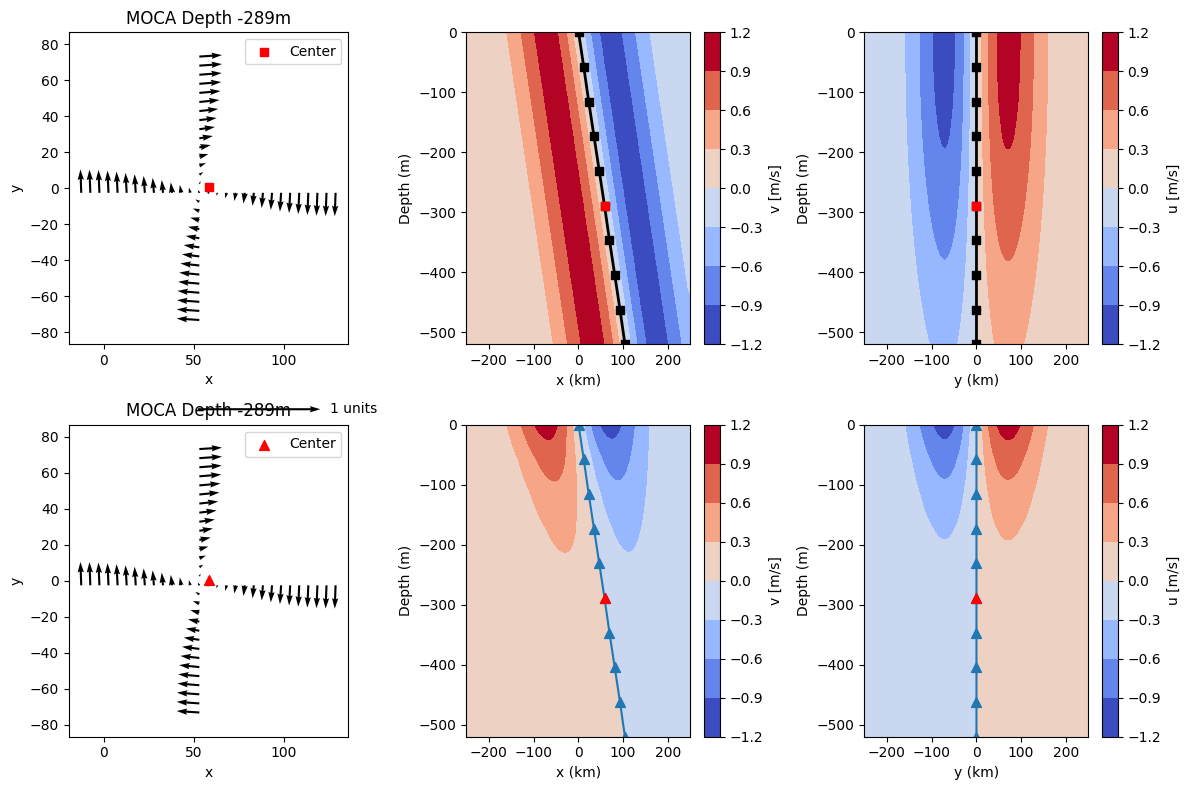

In [239]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

DEPTH_LVL = 5

depth_lvl = 'Depth' + str(DEPTH_LVL)

############################# Tilt #############################

dfx = depth_dics_MOCA[depth_lvl]['dfx']
dfy = depth_dics_MOCA[depth_lvl]['dfy']
x1, y1 = dfx.x, dfx.y
x2, y2 = dfy.x, dfy.y
u1, v1 = dfx.u1, dfx.v1
u2, v2 = dfy.u2, dfy.v2

q11, q12, q22 = depth_dics_MOCA[depth_lvl]['q11'], depth_dics_MOCA[depth_lvl]['q12'], depth_dics_MOCA[depth_lvl]['q22']
xc_lvl, yc_lvl = depth_dics_MOCA[depth_lvl]['xc'], depth_dics_MOCA[depth_lvl]['yc']
depth = depth_dics_MOCA[depth_lvl]['Depth']
s = 5.991

Q = np.array([[q11, q12], [q12, q22]])
if not is_pos_def(Q):
    Q = -Q

num_points = 100
theta = np.linspace(0, 2 * np.pi, num_points)
ellipse = np.array([np.cos(theta), np.sin(theta)])
eigvals, eigvecs = np.linalg.eig(Q)
# if np.any(eigvals <= 0):
#     raise ValueError(f"Matrix Q is not positive definite. Eigenvalues: {eigvals}")

axes = np.sqrt(s / eigvals)
ellipse_transformed = eigvecs @ np.diag(axes) @ ellipse
ellipse_transformed += np.array([[xc_lvl], [yc_lvl]])

xc_MOCA, yc_MOCA, zc_MOCA = [], [], []
for depth_dic in depth_dics_MOCA.values():
    xc_MOCA.append(depth_dic['xc'])
    yc_MOCA.append(depth_dic['yc'])
    zc_MOCA.append(depth_dic['Depth'])

# First subplot
axs[0,0].quiver(x1, y1, u1, v1)
axs[0,0].quiver(x2, y2, u2, v2)
# axs[0,0].fill(ellipse_transformed[0], ellipse_transformed[1], color='lightblue', alpha=0.5)
# axs[0,0].plot(ellipse_transformed[0], ellipse_transformed[1], color='blue')
axs[0,0].scatter([xc_lvl], [yc_lvl], color='red', zorder=5, label='Center', s=35, marker='s')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')
axs[0,0].legend()
axs[0,0].set_title(f'MOCA Depth {depth:.0f}m')
axs[0,0].axis('equal')

# Second subplot
v_cross = V_tilt[:, V_tilt.shape[1]//2, :]
v_data_range = np.nanmax(np.abs(v_cross))
X, Z = np.meshgrid(x_tilt, z_tilt)
c1 = axs[0,1].contourf(X, Z, v_cross.T, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
# c1_contour = axs[0,1].contour(X, Z, v_cross.T, levels=[0], colors='black', linestyles='--')
axs[0,1].set_xlabel('x (km)')
axs[0,1].set_ylabel('Depth (m)')
axs[0,1].plot(xc_MOCA, zc_MOCA, '-', linewidth=2, color='k')
axs[0,1].scatter(xc_MOCA, zc_MOCA, s=35, marker='s', color='k')
axs[0,1].scatter(xc_lvl, z_tilt[DEPTH_LVL], color='red', zorder=5, label='Center', s=35, marker='s')
fig.colorbar(c1, ax=axs[0,1], label='v [m/s]')

# Third subplot
u_cross = U_tilt[U_tilt.shape[0]//2, :, :]
u_data_range = np.nanmax(np.abs(u_cross))
Y, Z = np.meshgrid(y_tilt, z_tilt)
c2 = axs[0,2].contourf(Y, Z, u_cross.T, cmap='coolwarm', vmin=-u_data_range, vmax=u_data_range)
# c2_contour = axs[0,2].contour(Y, Z, u_cross.T, levels=[0], colors='black', linestyles='--')
axs[0,2].set_xlabel('y (km)')
axs[0,2].set_ylabel('Depth (m)')
axs[0,2].plot(yc_MOCA, zc_MOCA, '-', linewidth=2, color='k')
axs[0,2].scatter(yc_MOCA, zc_MOCA, s=35, marker='s', color='k')
axs[0,2].scatter(yc_lvl, z_tilt[DEPTH_LVL], color='red', zorder=5, label='Center', s=35, marker='s')
fig.colorbar(c2, ax=axs[0,2], label='u [m/s]')


############################# Tilt Tapered #############################

dfx = depth_dics_MOCA_tap[depth_lvl]['dfx']
dfy = depth_dics_MOCA_tap[depth_lvl]['dfy']
x1, y1 = dfx.x, dfx.y
x2, y2 = dfy.x, dfy.y
u1, v1 = dfx.u1, dfx.v1
u2, v2 = dfy.u2, dfy.v2

q11, q12, q22 = depth_dics_MOCA_tap[depth_lvl]['q11'], depth_dics_MOCA_tap[depth_lvl]['q12'], depth_dics_MOCA_tap[depth_lvl]['q22']
xc_lvl, yc_lvl = depth_dics_MOCA_tap[depth_lvl]['xc'], depth_dics_MOCA_tap[depth_lvl]['yc']
depth = depth_dics_MOCA_tap[depth_lvl]['Depth']
s = 5.991

Q = np.array([[q11, q12], [q12, q22]])
if not is_pos_def(Q):
    Q = -Q

num_points = 100
theta = np.linspace(0, 2 * np.pi, num_points)
ellipse = np.array([np.cos(theta), np.sin(theta)])
eigvals, eigvecs = np.linalg.eig(Q)
# if np.any(eigvals <= 0):
#     raise ValueError(f"Matrix Q is not positive definite. Eigenvalues: {eigvals}")

axes = np.sqrt(s / eigvals)
ellipse_transformed = eigvecs @ np.diag(axes) @ ellipse
ellipse_transformed += np.array([[xc_lvl], [yc_lvl]])

xc_MOCA_tap, yc_MOCA_tap, zc_MOCA_tap = [], [], []
for depth_dic in depth_dics_MOCA_tap.values():
    xc_MOCA_tap.append(depth_dic['xc'])
    yc_MOCA_tap.append(depth_dic['yc'])
    zc_MOCA_tap.append(depth_dic['Depth'])

# First subplot
quiver_plot = axs[1, 0].quiver(x1, y1, u1, v1)
magnitude = 1  # adjust this to represent a specific velocity magnitude
axs[1, 0].quiverkey(quiver_plot, X=0.9, Y=1.05, U=magnitude, label=f'{magnitude} units', labelpos='E')

axs[1,0].quiver(x2, y2, u2, v2)
# axs[1,0].fill(ellipse_transformed[0], ellipse_transformed[1], color='lightblue', alpha=0.5)
# axs[1,0].plot(ellipse_transformed[0], ellipse_transformed[1], color='blue')
axs[1,0].scatter(xc_lvl, yc_lvl, color='red', zorder=5, label='Center', s=50, marker='^')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')
axs[1,0].legend()
axs[1,0].set_title(f'MOCA Depth {depth:.0f}m')
axs[1,0].axis('equal')

# Second subplot
v_cross = V_tilt_tap[:, V_tilt_tap.shape[1]//2, :]
v_data_range = np.nanmax(np.abs(v_cross))
X, Z = np.meshgrid(x_tilt_tap, z_tilt_tap)
c1 = axs[1,1].contourf(X, Z, v_cross.T, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
# c1_contour = axs[1,1].contour(X, Z, v_cross.T, levels=[0], colors='black', linestyles='--')
axs[1,1].set_xlabel('x (km)')
axs[1,1].set_ylabel('Depth (m)')
axs[1,1].plot(xc_MOCA_tap, zc_MOCA_tap, '-', linewidth=1.5)
axs[1,1].scatter(xc_MOCA_tap, zc_MOCA_tap, s=50, marker='^')
axs[1,1].scatter(xc_lvl, z_tilt_tap[DEPTH_LVL], color='red', zorder=5, label='Center', s=50, marker='^')
fig.colorbar(c1, ax=axs[1,1], label='v [m/s]')

# Third subplot
u_cross = U_tilt_tap[U_tilt_tap.shape[0]//2, :, :]
u_data_range = np.nanmax(np.abs(u_cross))
Y, Z = np.meshgrid(y_tilt_tap, z_tilt_tap)
c2 = axs[1,2].contourf(Y, Z, u_cross.T, cmap='coolwarm', vmin=-u_data_range, vmax=u_data_range)
# c2_contour = axs[1,2].contour(Y, Z, u_cross.T, levels=[0], colors='black', linestyles='--')
axs[1,2].set_xlabel('y (km)')
axs[1,2].set_ylabel('Depth (m)')
axs[1,2].plot(yc_MOCA_tap, zc_MOCA_tap, '-', linewidth=1.5)
axs[1,2].scatter(yc_MOCA_tap, zc_MOCA_tap, s=50, marker='^')
axs[1,2].scatter(yc_lvl, z_tilt_tap[DEPTH_LVL], color='red', zorder=5, label='Center', s=50, marker='^')
fig.colorbar(c2, ax=axs[1,2], label='u [m/s]')

plt.tight_layout()
plt.show()

## LANM

In [63]:
def calc_lnam(x, y, uu, vv):
    f = -1  # SH
    # Initialize arrays for spatial differences
    dx, dy = np.zeros_like(x), np.zeros_like(x)
    dux, duy, dvx, dvy = np.zeros_like(x), np.zeros_like(x), np.zeros_like(x), np.zeros_like(x)
    
    # Finite spatial element directly in meters
    dx[1:-1, 1:-1] = x[1:-1, 2:] - x[1:-1, :-2]
    dy[1:-1, 1:-1] = y[2:, 1:-1] - y[:-2, 1:-1]
    
    # Speed element in m/s
    dux[1:-1, 1:-1] = uu[1:-1, 2:] - uu[1:-1, :-2]
    duy[1:-1, 1:-1] = uu[2:, 1:-1] - uu[:-2, 1:-1]
    dvx[1:-1, 1:-1] = vv[1:-1, 2:] - vv[1:-1, :-2]
    dvy[1:-1, 1:-1] = vv[2:, 1:-1] - vv[:-2, 1:-1]
    
    # Calculate Okubo-Weiss criteria and vorticity
    # sn = (dux / dx) - (dvy / dy)
    # ss = (dvx / dx) + (duy / dy)
    # om = (dvx / dx) - (duy / dy)
    # div = (dux / dx) + (dvy / dy)
    
    epsilon = 1e-10  # A small number to prevent division by zero
    sn = np.divide((dux / (dx + epsilon)) - (dvy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    ss = np.divide((dvx / (dx + epsilon)) + (duy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    om = np.divide((dvx / (dx + epsilon)) - (duy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    div = np.divide((dux / (dx + epsilon)) + (dvy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    
    vorticity = om * np.sign(f)
    okubo = sn**2 + ss**2 - om**2  # in s^-2
    
    # Initialization
    LNAM, LOW = np.zeros_like(uu), np.full_like(uu, np.nan)
    b = np.ones_like(x, dtype=int)
    borders = np.max(b) + 1
    
    # Loop through domain to calculate LNAM and LOW
    for i in range(borders, len(vv[:, 0]) - borders + 1):
        for j in range(borders, len(vv[0, :]) - borders + 1):
            if not np.isnan(vv[i, j]):
                OW = okubo[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                LOW[i, j] = np.nanmean(OW)
                
                xlocal = x[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ylocal = y[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ulocal = uu[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                vlocal = vv[i - b[i, j]:i + b[i, j] + 1, j - b[i, j] + 1]
                
                coordcentre = (xlocal.shape[0] - 1) // 2
                d_xcentre = (xlocal - xlocal[coordcentre, coordcentre])
                d_ycentre = (ylocal - ylocal[coordcentre, coordcentre])
                
                cross = (d_xcentre * vlocal) - (d_ycentre * ulocal)
                dot = (ulocal * d_xcentre) + (vlocal * d_ycentre)
                produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
                sumdp = np.sum(dot) + np.sum(produit)
                
                LNAM[i, j] = np.sum(cross) / sumdp * np.sign(f) if sumdp != 0 else 0
    
    LNAM[np.isnan(LNAM)] = 0
    return LNAM, LOW


In [65]:
depth_dics_LNAM = {}
for depth_lvl in range(U_tilt.shape[-1]):
    xx, yy = np.meshgrid(x_tilt, y_tilt)
    lnam, low = calc_lnam(xx, yy, U_tilt[:,:,depth_lvl], V_tilt[:,:,depth_lvl])
    if np.any(np.isfinite(lnam)):
        ic, jc = np.unravel_index(np.nanargmax(abs(lnam)), lnam.shape)
        ic, jc = int(ic), int(jc)
        depth_dics_LNAM['Depth'+str(depth_lvl)] = {'lnam': lnam, 'ic': ic, 'jc': jc,
                                                   'xc': x_tilt[ic], 'yc': y_tilt[jc], 'Depth': float(z_tilt[depth_lvl])}

Depth -462


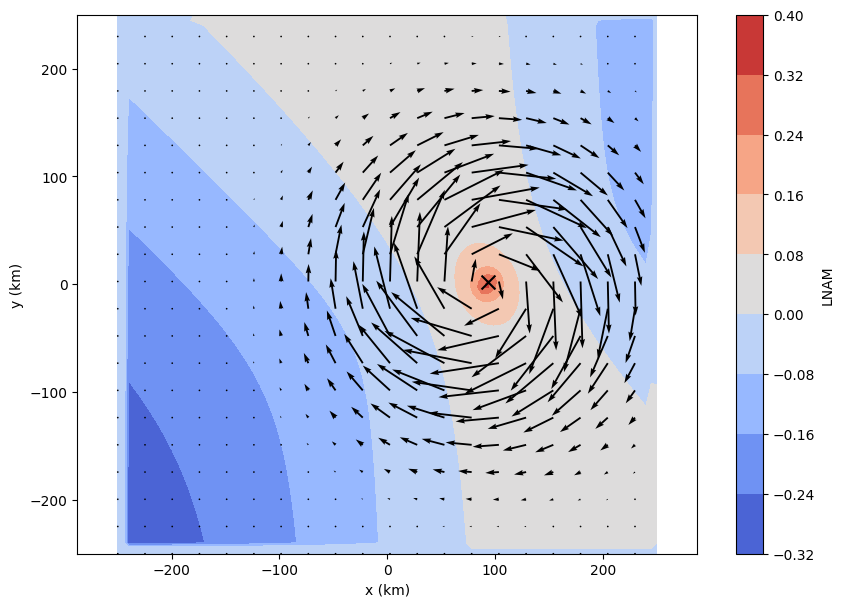

In [101]:
DEPTH_LVL = 8

depth_dic = depth_dics_LNAM['Depth'+str(DEPTH_LVL)]

plt.figure(figsize=(10,7))

c = plt.contourf(x_tilt, y_tilt, depth_dic['lnam'].T, cmap='coolwarm')
plt.scatter(depth_dic['xc'], depth_dic['yc'], color='k', marker='x', s=100)
plt.colorbar(c, label='LNAM')


spacing = 5
plt.quiver(x_tilt[::spacing], y_tilt[::spacing], U_tilt[::spacing,::spacing,DEPTH_LVL].T, V_tilt[::spacing,::spacing,DEPTH_LVL].T)

plt.axis('equal')
plt.xlabel('x (km)')
plt.ylabel('y (km)')

print('Depth ' + str(round(z_tilt[DEPTH_LVL])))

In [87]:
depth_dics_LNAM_tap = {}
for depth_lvl in range(U_tilt_tap.shape[-1]):
    xx, yy = np.meshgrid(x_tilt_tap, y_tilt_tap)
    lnam, low = calc_lnam(xx, yy, U_tilt_tap[:,:,depth_lvl], V_tilt_tap[:,:,depth_lvl])
    if np.any(np.isfinite(lnam)):
        ic, jc = np.unravel_index(np.nanargmax(abs(lnam)), lnam.shape)
        ic, jc = int(ic), int(jc)
        depth_dics_LNAM_tap['Depth'+str(depth_lvl)] = {'lnam': lnam, 'ic': ic, 'jc': jc,
                                                   'xc': x_tilt_tap[ic], 'yc': y_tilt_tap[jc], 'Depth': float(z_tilt_tap[depth_lvl])}

Text(0, 0.5, 'y (km)')

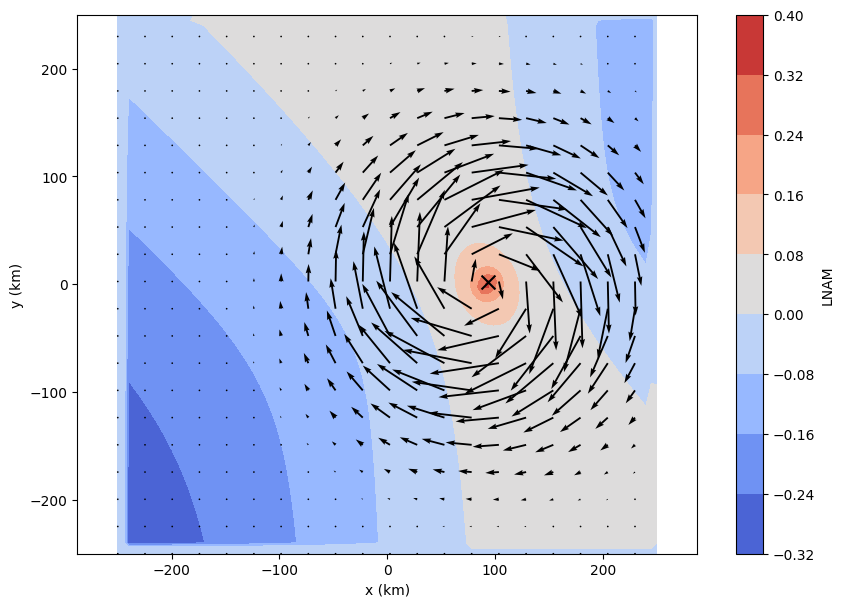

In [93]:
DEPTH_LVL = 8

depth_dic = depth_dics_LNAM_tap['Depth'+str(DEPTH_LVL)]

plt.figure(figsize=(10,7))

c = plt.contourf(x_tilt_tap, y_tilt_tap, depth_dic['lnam'].T, cmap='coolwarm')
plt.scatter(depth_dic['xc'], depth_dic['yc'], color='k', marker='x', s=100)
plt.colorbar(c, label='LNAM')

spacing = 5
plt.quiver(x_tilt_tap[::spacing], y_tilt_tap[::spacing],
           U_tilt_tap[::spacing,::spacing,DEPTH_LVL].T, V_tilt_tap[::spacing,::spacing,DEPTH_LVL].T)

plt.axis('equal')
plt.xlabel('x (km)')
plt.ylabel('y (km)')

Tapered exact same! Good pro, means it doesn't care = robust.

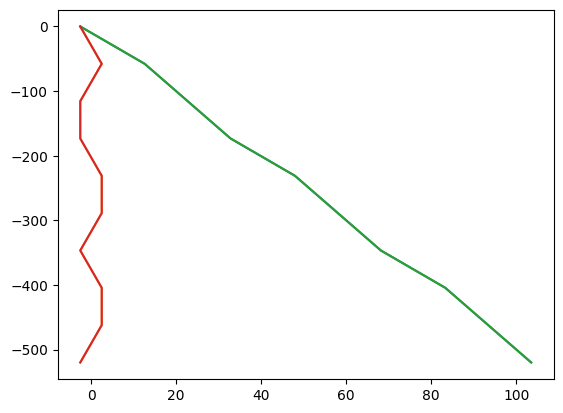

In [96]:
xc_LNAM, yc_LNAM, zc_LNAM = [], [], []
for depth_dic in depth_dics_LNAM.values():
    xc_LNAM.append(depth_dic['xc'])
    yc_LNAM.append(depth_dic['yc'])
    zc_LNAM.append(depth_dic['Depth'])

plt.plot(xc_LNAM, zc_LNAM)
plt.plot(yc_LNAM, zc_LNAM)

xc_LNAM_tap, yc_LNAM_tap, zc_LNAM_tap = [], [], []
for depth_dic in depth_dics_LNAM_tap.values():
    xc_LNAM_tap.append(depth_dic['xc'])
    yc_LNAM_tap.append(depth_dic['yc'])
    zc_LNAM_tap.append(depth_dic['Depth'])

plt.plot(xc_LNAM_tap, zc_LNAM_tap)
plt.plot(yc_LNAM_tap, zc_LNAM_tap)

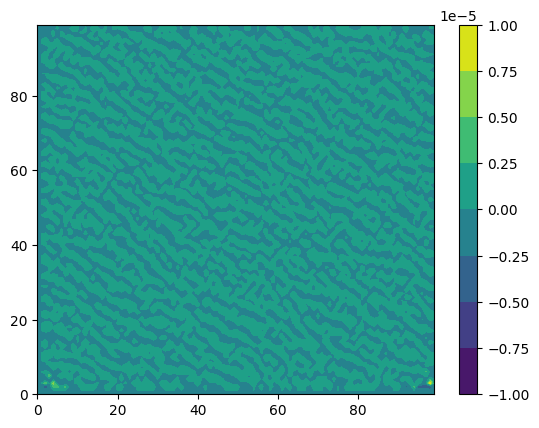

In [106]:
plt.contourf(depth_dics_LNAM['Depth'+str(DEPTH_LVL)]['lnam'] - depth_dics_LNAM_tap['Depth'+str(DEPTH_LVL)]['lnam'])
plt.colorbar()

The same !